# Example 4: Symmetry Mpemba Effects in Quantum circuits 
## Symmetry: U(1)

### Markovian


In [ ]:
import numpy as np
from functools import reduce
import functions as fn
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from circuit_obj import Circuit
from itertools import product
from matplotlib import cm
from matplotlib.colors import LogNorm
from scipy.special import comb
import scipy.linalg as la
import helpers as hl
ls_styles = hl.ls_styles

# from joblib import Parallel, delayed
colors = ["#9b4b2a", "#ff7f31", "#fce3a4"]
cmap1 = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
norm = plt.Normalize(vmin=0, vmax=np.pi)
smJ = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)


In [2]:
N = 8

# Circuit parameters
T = 100 # Number of time steps
circuit_realizations = 500 # Number of realizations of the circuit
symmetry = ['U1', 'SU2', 'Z2', 'ZK'][0] # Symmetry of the circuit
geometry = ['random', 'brickwork'][1] # Geometry of the circuit
K = 2  # Locality of the gates
alphaT = 3 # Parameter to slice the circuit thinner

# Mask parameters
Ns = 6
Ne = N - Ns
qkeep = range(Ne, N)
qthrow = range(Ne, N)
projectors_se, U_U1_se = fn.build_projectors(N)
projectors_s, U_U1_s = fn.build_projectors(Ns) 
projectors_e, U_U1_e = fn.build_projectors(Ne)
sectors_se = np.array([int(comb(N, int(N/2+m))) for m in np.arange(-N/2, N/2+1)])
sectors_s = np.array([int(comb(Ns, int(Ns/2+m))) for m in np.arange(-Ns/2, Ns/2+1)])

masks_dict = fn.load_mask_memory(N, (2 if symmetry!='ZK' else K))
masks_dict.keys(), [(len(masks_dict[i]),len(masks_dict[i][0])) for i in range(N)]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(dict_keys([0, 1, 2, 3, 4, 5, 6, 7]),
 [(4, 64), (4, 64), (4, 64), (4, 64), (4, 64), (4, 64), (4, 64), (4, 64)])

In [3]:
def initial_state(N, qkeep, theta, state_phases):
    '''
    Create the initial state as (exp(-i theta/2 sigma_y) |0>)^\otimes N
    '''
    r_y = fn.r_y
    Ns = len(qkeep)
    Ne = N - Ns
            
    state_s = reduce(np.kron, [r_y(theta) @ np.array([1, 0j])]*Ns)
    rho_s = np.outer(state_s, state_s.conj())

    rho_e = np.eye(2**Ne, dtype=complex)
    rho_e = rho_e / np.trace(rho_e)

    return np.kron(rho_e, rho_s)

# def initial_state(N, qkeep, theta, state_phases):
#     '''
#     Create the initial state as (exp(-i theta/2 sigma_y) |0>)^\otimes N
#     '''
#     assert theta in np.arange(Ns+1), "Theta must be less / eq than Ns"
    
#     state_s = np.zeros((2**Ns,), dtype=complex)
#     state_s[0] = 1.0  # Start with the |0> state
    
#     start = sum(sectors_s[:theta])
#     end = start + sectors_s[theta]
#     state_s[start:end] = 1.0
#     state_s = U_U1_s @ state_s
    
#     rho_s = np.outer(state_s, state_s.conj())
#     rho_s = rho_s / np.trace(rho_s)

#     rho_e = np.ones((2**Ne, 2**Ne), dtype=complex)
#     rho_e = rho_e / np.trace(rho_e)
#     rho_e = fn.manual_U1_tw(rho_e, projectors_e)

#     return np.kron(rho_e, rho_s)


from scipy.linalg import expm

def apply_k_local_yy(state: np.ndarray, Ns: int, k: int, theta: float) -> np.ndarray:
    """
    Given an Ns-qubit state vector `state` (of length 2**Ns), apply k-local
    rotations around Y of angle `theta`. Concretely, for each disjoint block of
    k qubits (0..k-1, k..2k-1, 2k..3k-1, …), apply the unitary
        U_k = exp(-i * (Y⊗Y⊗⋯⊗Y) * (theta/2))
    where Y is the Pauli-Y matrix.  Blocks that don't fit exactly (if Ns % k != 0)
    are left untouched.

    Example (k=2): this applies U_2 = exp(-i⋅(Y⊗Y)⋅(θ/2)) to qubit-pairs (0,1), (2,3), (4,5), …

    Args:
        state: 1D complex numpy array of length 2**Ns, representing the input state.
        Ns:    Number of qubits.
        k:     Locality size.  Must satisfy 1 ≤ k ≤ Ns.
        theta: Rotation angle.

    Returns:
        new_state: 1D complex numpy array of length 2**Ns after applying all k-local
                   Y⊗…⊗Y rotations on each disjoint block of size k.
    """
    # Verify input
    if state.ndim != 1 or state.shape[0] != (1 << Ns):
        raise ValueError(f"state must be a 1D vector of length 2**{Ns}, got shape {state.shape}.")

    if not (1 <= k <= Ns):
        raise ValueError(f"k must be between 1 and Ns={Ns}, got k={k}.")

    # Define single-qubit Pauli-Y
    Y = np.array([[0, -1j],
                  [1j,  0]], dtype=complex)

    # Build Y⊗Y⊗⋯⊗Y (k times)
    Yk = Y
    for _ in range(1, k):
        Yk = np.kron(Yk, Y)

    # Build the k-qubit rotation U_k = exp(-i * (Y^⊗k) * (theta/2))
    U_k = expm(-1j * (theta / 2) * Yk)
    dim_full = 1 << Ns

    # Reshape the state into an Ns-dimensional tensor of shape (2,2,…,2)
    psi_tensor = state.reshape((2,) * Ns)

    # We'll apply U_k to blocks [0..k-1], [k..2k-1], [2k..3k-1], … until we run out.
    # If Ns is not divisible by k, the final qubits (Ns - (Ns//k)*k) remain as is.
    n_blocks = Ns // k

    new_tensor = psi_tensor.copy()

    for block_index in range(n_blocks):
        # The qubits for this block are indices:
        #   q_inds = [block_index*k, block_index*k + 1, …, block_index*k + (k-1)]
        q_inds = list(range(block_index * k, block_index * k + k))

        # We want to apply U_k on those k axes of new_tensor simultaneously.
        # Strategy:
        #   1. Move the k target axes to the front.
        #   2. Reshape to (2^k, 2^(Ns - k)).
        #   3. Multiply by U_k on the left.
        #   4. Reshape back and invert the transpose.

        # (1) Compute the permutation that brings q_inds to front
        remaining_axes = [i for i in range(Ns) if i not in q_inds]
        perm = q_inds + remaining_axes

        # Transpose new_tensor so that the k target axes are in front
        transposed = np.transpose(new_tensor, axes=perm)

        # (2) Reshape to a 2D array of shape (2^k, 2^(Ns-k))
        dim_block = 1 << k
        dim_rest = (1 << Ns) // dim_block
        reshaped = transposed.reshape((dim_block, dim_rest))

        # (3) Apply U_k to the first index (k-qubit block)
        updated = U_k @ reshaped  # shape: (2^k, 2^(Ns-k))

        # (4) Reshape back to shape (2,2,...,2) and invert the permutation
        back_reshaped = updated.reshape([2] * k + [2] * (Ns - k))
        # To invert the transpose, we need the inverse permutation
        # If perm = [p0, p1, …, p_{Ns-1}], then invperm[perm[i]] = i
        invperm = np.argsort(perm)
        new_tensor = np.transpose(back_reshaped, axes=invperm)

    # Finally, flatten back to a state vector
    new_state = new_tensor.reshape((dim_full,))
    return new_state



def initial_state1(N, qkeep, theta, state_phases, K, beta=0):
    '''
    Create the initial state as (exp(-i theta/2 sigma_y) |0>)^\otimes N
    '''
    # assert theta in np.arange(Ns+1), "Theta must be less / eq than Ns"
    
    # state_s = np.ones((2**Ns,), dtype=np.complex128)    
    # rho_s = np.outer(state_s, state_s.conj())
    # rho_s = rho_s / np.trace(rho_s)
    # rho_s_modes = fn.asymmetry_modes(rho_s, sectors_s)
    # rho_s = rho_s_modes[0] + rho_s_modes[theta].conj().T + rho_s_modes[theta]
    # rho_s = U_U1_s @ rho_s @ U_U1_s.conj().T
    
    
    state_s = np.zeros((2**Ns,), dtype=complex)
    state_s[0] = 1.0  # Start with the |0> state
    state_s = apply_k_local_yy(state_s, Ns, K, theta)
    rho_s = np.outer(state_s, state_s.conj())

    rho_e = np.eye(2**Ne, dtype=complex)
    rho_e = rho_e / np.trace(rho_e)

    return np.kron(rho_e, rho_s)


[(0.1, 0.43450283200962236),
 (0.2, 0.6605160620921037),
 (0.5, 1.039720770839917)]

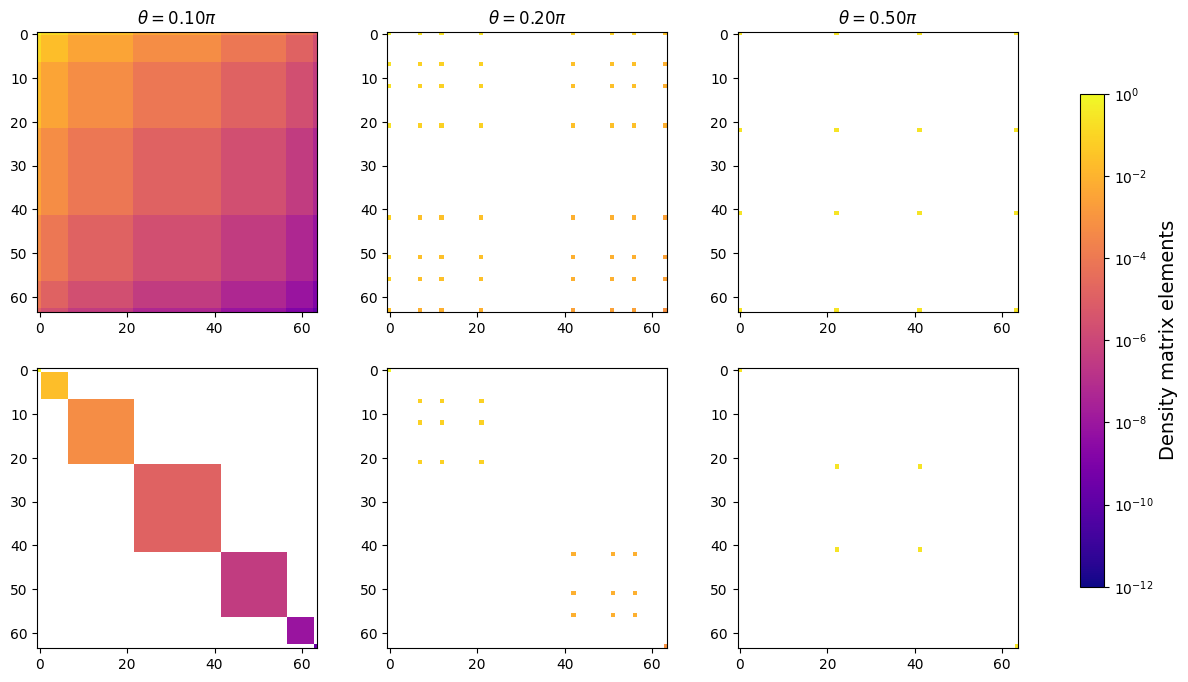

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm


# np.linspace(0.01, 0.19, 5) * np.pi
if symmetry == 'U1':
    thetas = np.array([.1, .2, .5])*np.pi # theta
    Ks = np.array([1, 2, 3])

# fig, axs = plt.subplots(2, len(thetas), figsize=(16, 8))
fig, axs = plt.subplots(2, len(thetas), figsize=(16, 8))

renyis = []
states = []
for idx, theta in enumerate(thetas):
    state = initial_state1(N, qkeep, theta, 'homogenous', Ks[idx])
    # state = initial_state(N, qkeep, theta, 'homogenous')
    
    rho_s = fn.ptrace(state, qkeep)
    rho_s_tw = fn.manual_U1_tw(rho_s, projectors_s)

    cmap = cm.plasma.copy()
    cmap.set_bad(color='white')  # or 'none' for full transparency
    
    d1 = np.ma.masked_less(np.abs(U_U1_s.conj().T @ (rho_s) @ U_U1_s), 1e-12)
    d2 = np.ma.masked_less(np.abs(U_U1_s.conj().T @ (rho_s_tw) @ U_U1_s), 1e-12)
    renyis.append(fn.renyi_divergence_sym(rho_s, symmetry, 1).real)  
    states.append(state)
    im = axs[0, idx].imshow(d1, cmap=cmap, norm=LogNorm(1e-12,1e0))
    axs[1, idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12,1e0))
    axs[0, idx].set_title(rf'$\theta = {theta/np.pi:.2f}\pi$')

fig1 = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.8)
fig1.set_label('Density matrix elements', fontsize=14)

assert all(np.diff(renyis) >= 0), "Renyis do not grow with theta"
[*zip(thetas/np.pi, renyis)]


[1. 0. 0. 0.]
[1.         0.72153924 0.75170786 0.35355339]
[1. 1. 1. 1.]


Text(0.5, 1.0, 'Asymmetry modes')

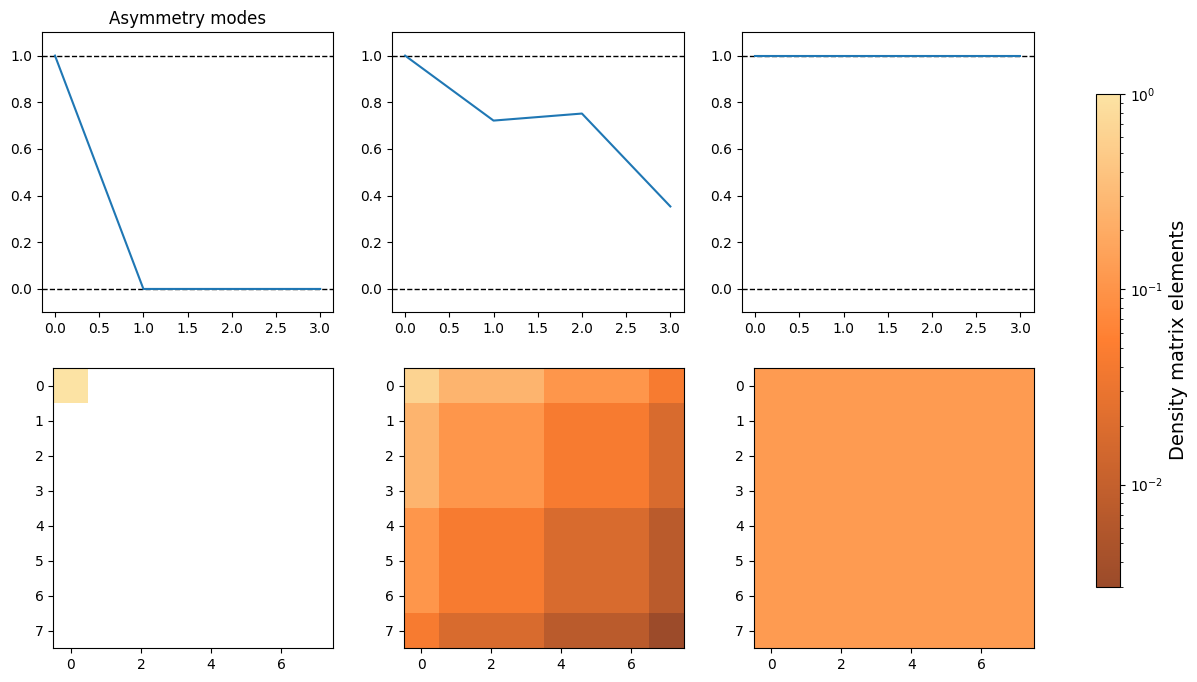

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

example_N = 4
example_Ns = 3
example_Ne = example_N - example_Ns
example_qkeep = range((example_N-example_Ns), example_N)
example_sectors_s = np.array([int(comb(example_Ns, int(example_Ns/2+m))) 
                              for m in np.arange(-example_Ns/2, example_Ns/2+1)])
projectors_se_example, U_U1_se_example = fn.build_projectors(example_N)
projectors_s_example, U_U1_s_example = fn.build_projectors(example_Ns) 
if example_Ne != 1:
    projectors_e_example, U_U1_e_example = fn.build_projectors(example_Ne)
else:
    projectors_e_example = {-.5: np.array([1, 0]), .5: np.array([0, 1])}
    U_U1_e_example = np.eye(example_Ne)
    
examples_states = [initial_state(example_N, example_qkeep, theta, 'homogenous') for theta in [0, np.pi/4, np.pi/2]]
examples_states = [fn.ptrace(state, example_qkeep) for state in examples_states]

modes = fn.asymmetry_modes(examples_states[-1], example_sectors_s)

norms_norm = np.array([fn.compute_norm(modes[idx]) for idx in range(len(modes))])

for idx in range(example_Ns):
    ax = axs[0,idx]
    ax.axhline(0, color='black', lw=1, ls='--')
    ax.axhline(1, color='black', lw=1, ls='--')
    # compute modes
    rho_s = examples_states[idx]
    modes = fn.asymmetry_modes(rho_s, example_sectors_s)

    # compute norms
    norms = np.array([fn.compute_norm(modes[idx]) for idx in range(len(modes))])
    norms = norms / norms_norm  # Normalize by the first mode
    print(norms)
    ax.plot(norms)
    ax.set_ylim(-.1, 1.1)
    
    
    rho_s_tw = fn.manual_U1_tw(rho_s, projectors_s_example)

    cmap1.set_bad(color='white')  # or 'none' for full transparency
    
    d1 = np.ma.masked_less(np.abs(U_U1_s_example.conj().T @ (rho_s) @ U_U1_s_example), 1e-12)
    d2 = np.ma.masked_less(np.abs(U_U1_s_example.conj().T @ (rho_s_tw) @ U_U1_s_example), 1e-12)
    im = axs[1,idx].imshow(d1, cmap=cmap1, norm=LogNorm(0.003, 1e0), interpolation='none')

# color bar on axs1
fig1 = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.8)
fig1.set_label('Density matrix elements', fontsize=14)
axs[0,0].set_title('Density matrix of the state')
axs[0,0].set_title('Asymmetry modes')


# Check subsectors of initial states:

In [ ]:
circuits = []

h_list_all = np.load(f'data/U1_rnd_parameters.npy')
h_list_all_ = np.load(f'data/U1_rnd_parameters_400.npy')
h_list_all = np.vstack((h_list_all, h_list_all_))
print('Loaded U1 parameters')

for circuit_realization in range(circuit_realizations):
    if symmetry == 'U1':
        h_list = h_list_all[circuit_realization] /alphaT
        gates = [fn.gen_u1([*h]) for h in h_list]
    elif symmetry == 'SU2':
        h_list = np.random.uniform(-np.pi, np.pi, 1*N).reshape(N, 1) /alphaT
        gates = [fn.gen_su2(*h) for h in h_list]

    order = fn.gen_gates_order(N, geometry=geometry)    
    circuit = Circuit(N=N, T=T, gates=gates, order=order, symmetry=symmetry)
    circuit.projectors = projectors_s
    circuits.append(circuit)

In [ ]:
state = states[0]
sigma_env = fn.ptrace(state, qthrow)

In [ ]:
%matplotlib inline
U = circuits[2].generate_unitary(masks_dict)
# fn.printm(U_in_U1, cmap=cmap1)
U_in_U1 = U_U1_se.conj().T @ U @ U_U1_se
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
d1 = np.ma.masked_less(np.abs(U_in_U1), 1e-12)
ax.imshow(np.abs(d1), cmap=cmap1, norm=norm, interpolation='none')

In [ ]:
ds = 2**Ns
de = 2**(N - Ns)
dim = 2**N

# unitary
U = circuits[0].generate_unitary(masks_dict)

# random system state
psi = np.random.randn(ds,1) + 1j*np.random.randn(ds,1)
rho = psi @ psi.conj().T
rho /= np.trace(rho)

# random env pure state
phi = np.random.randn(de,1) + 1j*np.random.randn(de,1)
sigma_pure = phi @ phi.conj().T
sigma_pure /= np.trace(sigma_pure)

# random env mixed state
Y = np.random.randn(de, de) + 1j*np.random.randn(de, de)
sigma_mix = Y @ Y.conj().T
sigma_mix /= np.trace(sigma_mix)

for env_type, sigma in [('pure', sigma_pure), ('mixed', sigma_mix)]:
    S = hl.reduced_superop(U, N, Ns, sigma)
    out_super = hl.apply_superop(S, rho)
    out_direct = hl.partial_trace_after_unitary(U, rho, sigma)
    diff = np.max(np.abs(out_super - out_direct))
    print({
        'N': N, 'Ns': Ns, 'env': env_type, 'max_diff': diff
    })


In [ ]:
def compute_permutation_and_omegas(d_s, hw_list):
    """
    Returns:
      perm_full: list of indices that sorts vec‐basis by ascending ω = hw(n) − hw(m)
      omegas   : corresponding ω values in sorted order
    """
    rows_and_triplets = [
        (n + m * d_s, (n, m, hw_list[n] - hw_list[m]))
        for n in range(d_s)
        for m in range(d_s)
    ]
    rows_sorted = sorted(rows_and_triplets, key=lambda item: item[1][2])
    perm_full = [row_full for (row_full, (_n, _m, _ω)) in rows_sorted]
    omegas = [ω for (_row_full, (_n, _m, ω)) in rows_sorted]
    return perm_full, omegas

def compare_omega_blocks(S_perm, blocks_by_omega, d_s, hw_list):
    """
    For each distinct ω, extracts the corresponding block from S_perm and
    compares it with the direct block in blocks_by_omega. Prints max difference.
    """
    # Recompute omegas for each basis index (redundant if already computed)
    rows_and_triplets = [
        (n + m * d_s, (n, m, hw_list[n] - hw_list[m]))
        for n in range(d_s)
        for m in range(d_s)
    ]
    rows_sorted = sorted(rows_and_triplets, key=lambda item: item[1][2])
    ω_list = [triplet[2] for (_, triplet) in rows_sorted]

    unique_D, counts = np.unique(ω_list, return_counts=True)
    cum_counts = np.cumsum([0] + list(counts))

    for k, ω in enumerate(unique_D):
        start = cum_counts[k]
        stop = cum_counts[k + 1]
        B_full = S_perm[start:stop, start:stop]

        B_direct, _pair_list = blocks_by_omega[ω]
        assert B_full.shape == B_direct.shape

        diff = np.max(np.abs(B_full - B_direct))
        print(f"ω = {ω:>2d}, block-size = {B_full.shape[0]:>2d}, max-diff = {diff:.2e}")


def recompose_and_compare(S_perm, blocks_by_omega):
    """
    Reconstructs the full superoperator from ω-blocks and compares with S_perm.
    """
    unique_omegas = sorted(blocks_by_omega.keys())
    new_blocks = [blocks_by_omega[ω][0] for ω in unique_omegas]
    S_recomposed = hl.recompose_block_diag(new_blocks)

    diff = np.max(np.abs(S_recomposed - S_perm))
    print(f"Recomposed S max-diff = {diff:.2e}")
    return S_recomposed


circuit_index = 0  # Index of the circuit to use from circuits list     
 
# (1) Compute dimensions and (pairs_by_omega, hw_list)
d_s = 2**Ns
pairs_by_omega, hw_list = hl.build_pairs_by_omega(Ns)

# (2) Build the unitary U
U = circuits[circuit_index].generate_unitary(masks_dict)

# (3) Generate σ_env
state = states[0]
sigma_env = fn.ptrace(state, qthrow)


In [ ]:

# (4) Build direct ω-blocks and full superoperator
blocks_by_omega = hl.build_omega_blocks(U, N, Ns, sigma_env, pairs_by_omega)
S_full = hl.reduced_superop_full(U, N, Ns, sigma_env)

# (5) Compute permutation, permute S_full
perm_full, omegas = compute_permutation_and_omegas(d_s, hw_list)
S_perm = S_full[np.ix_(perm_full, perm_full)]

# (6) Compare each ω-block
compare_omega_blocks(S_perm, blocks_by_omega, d_s, hw_list)

# (7) Recompose and compare full superoperator
recompose_and_compare(S_perm, blocks_by_omega);


In [ ]:
U = circuits[circuit_realization].generate_unitary(masks_dict)
S = hl.reduced_superop(U, N, Ns, sigma_env)
S_full = hl.reduced_superop_full(U, N, Ns, sigma_env)
S_perm = S_full[np.ix_(perm_full, perm_full)]

assert np.allclose(S, S_full), "S and S_full do not match!"

S_ordered, perm, omegas = hl.reorder_superop_by_hw_diff(S, Ns)

# ─── 2) Build inv_perm and compute block‐sizes b[0..2Ns] ───
inv_perm = np.empty_like(perm)
inv_perm[perm] = np.arange(len(perm))

values, counts = np.unique(omegas, return_counts=True) 
count_dict = dict(zip(values, counts))
# b[0] = dim(ω=-Ns), b[1] = dim(ω=-Ns+1), …, b[2*Ns] = dim(ω=+Ns)
b = np.fromiter(count_dict.values(), dtype=int)
assert np.allclose(b, hl.asymmetry_block_sizes(Ns)), \
    f"Block sizes {b} do not match expected sizes for Ns={Ns}!"
sub_blocks = hl.split_block_diag(S_ordered, b)

# Split into (2*Ns+1) blocks of sizes b[0], b[1], …, b[2*Ns]
blocks_by_omega = hl.build_omega_blocks(U, N, Ns, sigma_env, pairs_by_omega)
new_blocks = [blocks_by_omega[ω ][0] for ω  in sorted(blocks_by_omega.keys())]
S_recomposed = hl.recompose_block_diag(new_blocks)

assert np.allclose(S_recomposed, S_perm), f"Recomposition failed!: max diff = " +\
    f"{np.max(np.abs(S_recomposed - S_perm)):.2e}"
    
inv_perm = np.empty_like(perm_full)
inv_perm[perm_full] = np.arange(len(perm_full))
S_fast = S_recomposed[np.ix_(inv_perm, inv_perm)]

assert np.allclose(S_fast, S_full), f"Recomposition failed in computational basis!: max diff = " +\
    f"{np.max(np.abs(S_fast - S_full)):.2e}"

In [ ]:
%matplotlib inline
import mplcursors
fig, ax = plt.subplots(2, 2*Ns+1, figsize=(16, 8))
# ax = ax.flatten()
for idx in range(2*Ns+1):
    block = new_blocks[idx]
    ω = idx - Ns
    d1 = np.ma.masked_less(np.abs(block), 1e-12)
    im = ax[0,idx].imshow(np.abs(d1), cmap=cmap1, norm=norm, interpolation='none')
    ax[0,idx].set_title(f"omega={ω }")
    # hl.attach_matrix_cursor(im, block, label="new block", hover=False)
    
    block1 = sub_blocks[idx]
    d2 = np.ma.masked_less(np.abs(block1), 1e-12)
    im = ax[1,idx].imshow(np.abs(d2), cmap=cmap1, norm=norm, interpolation='none')
    ax[1,idx].set_title(f"idx={idx}")
    # hl.attach_matrix_cursor(im, block1, label="sub block", hover=False)
    
    #hide the ticks
    ax[0,idx].set_xticks([])
    ax[0,idx].set_yticks([])
    ax[1,idx].set_xticks([])
    ax[1,idx].set_yticks([])
    
    assert np.allclose(block, block1.conj()), \
        f"Block {idx} does not match recomposed block: max diff = " +\
        f"{np.max(np.abs(block - block1)):.2e}"

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
d1 = np.ma.masked_less(np.abs(S_recomposed), 1e-12)
d2 = np.ma.masked_less(np.abs(S_perm), 1e-12)
d3 = np.ma.masked_less(np.abs(S_recomposed - S_perm), 1e-12)
print(f"Max diff: {np.max(np.abs(S_recomposed - S_perm)):.2e}")
ax[0].imshow(np.abs(d1), cmap=cmap1, norm=norm, interpolation='none')
ax[1].imshow(np.abs(d2), cmap=cmap1, norm=norm, interpolation='none')
ax[2].imshow(np.abs(d3), cmap=cmap1, norm=norm, interpolation='none')

In [ ]:
def quantum_state_similarity(rho: np.ndarray, sigma: np.ndarray) -> dict:
    """
    Compute similarity metrics between two density matrices.

    Returns a dictionary with:
      - 'hs_norm': Hilbert-Schmidt norm ||rho - sigma||_HS
      - 'hs_similarity': 1 - ||rho - sigma||_HS / (||rho||_HS + ||sigma||_HS)
          in [0,1], higher means more similar
      - 'overlap': Tr(rho @ sigma), the Hilbert-Schmidt overlap

    Parameters
    ----------
    rho : np.ndarray
        First density matrix (Hermitian, PSD, trace 1).
    sigma : np.ndarray
        Second density matrix (same shape as rho).

    Returns
    -------
    dict
        Dictionary of metrics.
    """
    # Convert to complex numpy arrays
    rho = np.asarray(rho, dtype=complex)
    sigma = np.asarray(sigma, dtype=complex)

    if rho.shape != sigma.shape:
        raise ValueError("rho and sigma must have the same shape")

    # Compute the difference and Hilbert-Schmidt norm
    delta = rho - sigma
    hs_sq = np.trace(np.conj(delta.T) @ delta)
    hs_norm = float(np.sqrt(np.real_if_close(hs_sq)))

    # Hilbert-Schmidt norms of rho and sigma
    norm_rho = float(np.sqrt(np.real_if_close(np.trace(np.conj(rho.T) @ rho))))
    norm_sigma = float(np.sqrt(np.real_if_close(np.trace(np.conj(sigma.T) @ sigma))))

    # Similarity measure in [0,1]
    denom = norm_rho + norm_sigma
    hs_similarity = 1.0 - hs_norm / denom if denom != 0 else 1.0

    # Overlap Tr(rho @ sigma)
    raw_overlap = np.trace(rho @ sigma)
    overlap = float(np.real(raw_overlap))

    return {
        'hs_norm': hs_norm,
        'hs_similarity': hs_similarity,
        'overlap': overlap
    }

def hs_similarity(rho, M):
    """Normalized Hilbert-Schmidt “fidelity” in [0,1]."""
    num   = np.abs(np.trace(M.conj().T @ rho))
    denom = np.linalg.norm(rho, 'fro') * np.linalg.norm(M, 'fro')
    return num/denom

def hs_distance(rho, M):
    num   = np.linalg.norm(rho - M, 'fro')
    denom = np.sqrt(np.linalg.norm(rho, 'fro')**2 +
                    np.linalg.norm(M  , 'fro')**2)
    return 1 - num/denom

def trace_distance(rho, M):
    """
    A normalized trace-distance-based similarity in [0,1]:
      1 when M == rho,
      0 when they are “as far apart as possible.”

    Steps:
      1. Renormalize each operator to unit 1-norm:
           rho' = rho  / ||rho||₁,   M' = M / ||M||₁
      2. Compute the trace-distance (nuclear norm):
           D = ½ || rho' - M' ||₁   in [0,1]
      3. Define similarity S = 1 - D   in [0,1].
    """
    # 1) normalize both to unit trace-norm
    norm_r = np.linalg.norm(rho, 1)
    norm_M = np.linalg.norm(M,   1)
    rho_n = rho / norm_r
    M_n   = M   / norm_M

    # 2) compute singular values of the difference
    delta = rho_n - M_n
    svals = la.svd(delta, compute_uv=False)

    # trace-distance = ½ sum(singular values)
    D = 0.5 * np.sum(svals)

    # 3) flip to similarity
    return 1.0 - D

def fidelity(rho, sigma, tol=1e-12):
    """
    Compute the Uhlmann fidelity F(rho, sigma) = [Tr sqrt(sqrt(rho) sigma sqrt(rho))]^2
    """
    # 1. Diagonalize rho
    lam, V = np.linalg.eigh(rho)
    # 2. Keep only non-zero eigenspace of rho
    keep = lam > tol
    lam, V = lam[keep], V[:, keep]
    # 3. Build the r x r sandwich matrix A = sqrt(lam) * (V^† sigma V) * sqrt(lam)
    S = V.conj().T @ sigma @ V
    sqrtlam = np.sqrt(lam)
    A = sqrtlam[:, None] * S * sqrtlam[None, :]
    # 4. Diagonalize A and sum sqrt of its positive eigenvalues
    eigs = np.linalg.eigvalsh(A)
    return (np.sum(np.sqrt(np.clip(eigs, 0, None))))**2


In [ ]:
# eigvals_per_omega_r = {}
# eigvals_per_omega_l = {}
# max_e_modes_r = {}
# second_e_modes_r = {}
# max_e_modes_l = {}
# second_e_modes_l = {}

# rho_e = np.ones((2**Ne, 2**Ne), dtype=complex)
# rho_e = fn.manual_U1_tw(rho_e, projectors_e)
# rho_e = rho_e / np.trace(rho_e)

# for circuit_realization in tqdm(range(circuit_realizations)):
#     # ─── 1) Build the unitary, form the reduced superoperator, reorder by hw‐difference ───
#     U = circuits[circuit_realization].generate_unitary(masks_dict)
#     S = reduced_superop(U, N, Ns, rho_e)
#     S_ordered, perm, omegas = reorder_superop_by_hw_diff(S, Ns)

#     # ─── 2) Build inv_perm and compute block‐sizes b[0..2Ns] ───
#     inv_perm = np.empty_like(perm)
#     inv_perm[perm] = np.arange(len(perm))

#     values, counts = np.unique(omegas, return_counts=True)
#     count_dict = dict(zip(values, counts))
#     # b[0] = dim(ω=-Ns), b[1] = dim(ω=-Ns+1), …, b[2*Ns] = dim(ω=+Ns)
#     b = np.fromiter(count_dict.values(), dtype=int)
#     assert np.allclose(b, asymmetry_block_sizes(Ns)), \
#         f"Block sizes {b} do not match expected sizes for Ns={Ns}!"

#     # Split into (2*Ns+1) blocks of sizes b[0], b[1], …, b[2*Ns]
#     sub_blocks = split_block_diag(S_ordered, b)
#     assert np.allclose(recompose_block_diag(sub_blocks), S_ordered), "Recomposition failed!"

#     # ─── 3) Diagonalize each block to get R_block and L_block, normalize them, then store ───
#     for idx, block in enumerate(sub_blocks):
#         ω = -Ns + idx

#         # 3a) Right eigenproblem on the block → largest‐magnitude eigenvector
#         eigvals_r, eigvecs_r = la.eig(block)
#         slowest_idx_r = np.argmax(np.log(np.abs(eigvals_r)))
#         raw_vec_r = eigvecs_r[:, slowest_idx_r].copy()
#         λ_r = eigvals_r[slowest_idx_r]

#         # 3b) Left eigenproblem on the block† → largest‐magnitude eigenvector
#         eigvals_l, eigvecs_l = la.eig(block.T.conj())
#         slowest_idx_l = np.argmax(np.log(np.abs(eigvals_l)))
#         raw_vec_l = eigvecs_l[:, slowest_idx_l].copy()
#         λ_l = eigvals_l[slowest_idx_l]
        
#         # 3c) Normalize in the block basis so that (L_block)† · (R_block) = 1
#         overlap_block = np.vdot(raw_vec_l, raw_vec_r)  # raw_vec_l.conj().T @ raw_vec_r
#         if abs(overlap_block) < 1e-14:
#             raise RuntimeError(
#                 f"Zero or too‐small overlap in block ω={ω}, realization {circuit_realization}"
#             )
#         raw_vec_l /= overlap_block.conj()
#         assert np.isclose(
#             np.vdot(raw_vec_l, raw_vec_r), 1.0, atol=1e-8
#         ), f"Normalization failed in block ω={ω}, real {circuit_realization}: {np.vdot(raw_vec_l, raw_vec_r)}"

#         # 3d) Now embed raw_vec_r and raw_vec_l back into “block‐flattened” form:
#         #     (i) Create a zero‐padded length‐2^{2*Ns} vector,
#         #     (ii) Insert the block vector into indices [start:end],
#         #     (iii) Then apply U_U1_s rotation and inv_perm when reconstructing later.
#         start = sum(b[:idx])
#         end   = start + b[idx]
        
#         flat_block_r = np.zeros((2**(2*Ns),), dtype=complex)
#         flat_block_r[start:end] = raw_vec_r
#         # Apply inv_perm to go back to the “pre‐block‐diagonal” ordering:
#         full_flat_r = flat_block_r[inv_perm]
#         # Reshape into 2^Ns x 2^Ns
#         mat_r = full_flat_r.reshape(2**Ns, 2**Ns)
#         # Rotate into the U1 basis:
#         R_ω = U_U1_s.conj().T @ mat_r @ U_U1_s

#         # 3e) Do the same for raw_vec_l:
#         flat_block_l = np.zeros((2**(2*Ns),), dtype=complex)
#         flat_block_l[start:end] = raw_vec_l
#         full_flat_l = flat_block_l[inv_perm]
#         mat_l = full_flat_l.reshape(2**Ns, 2**Ns)
#         L_ω = U_U1_s.conj().T @ mat_l @ U_U1_s

#         # 3f) Store the full right/left matrices (flattened) in max_e_modes_r/l:
#         #     We keep λ_r, and as the second entry we store R_ω.reshape(2^Ns*2^Ns)
#         max_e_modes_r[(circuit_realization, ω)] = (λ_r, R_ω.reshape(2**(2*Ns)))
#         max_e_modes_l[(circuit_realization, ω)] = (λ_l, L_ω.reshape(2**(2*Ns)))

#         eigvals_per_omega_r[(circuit_realization, ω)] = eigvals_r.copy()
#         eigvals_per_omega_l[(circuit_realization, ω)] = eigvals_l.copy()

#         # 3e) If there is more than one eigenvalue, pick the second‐slowest (right)
#         if len(eigvals_r) > 1:
#             eigvals_r_reduced = np.delete(eigvals_r, slowest_idx_r)
#             eigvecs_r_reduced = np.delete(eigvecs_r, slowest_idx_r, axis=1)
#             second_idx_r = np.argmax(np.log(np.abs(eigvals_r_reduced)))
#             second_e_modes_r[(circuit_realization, ω)] = (
#                 eigvals_r_reduced[second_idx_r],
#                 eigvecs_r_reduced[:, second_idx_r].copy()
#             )

#         # 3f) If there is more than one eigenvalue, pick the second‐slowest (left)
#         if len(eigvals_l) > 1:
#             eigvals_l_reduced = np.delete(eigvals_l, slowest_idx_l)
#             eigvecs_l_reduced = np.delete(eigvecs_l, slowest_idx_l, axis=1)
#             second_idx_l = np.argmax(np.log(np.abs(eigvals_l_reduced)))
#             second_e_modes_l[(circuit_realization, ω)] = (
#                 eigvals_l_reduced[second_idx_l],
#                 eigvecs_l_reduced[:, second_idx_l].copy()
#             )

#         # 3g) Check algebraic multiplicity = 1 for the slowest root (optional)
#         if np.sum(np.isclose(eigvals_r, eigvals_r[slowest_idx_r], atol=1e-10)) > 1:
#             print(f"Warning: block ω={ω} has multiple slowest eigenvalues "
#                   f"for realization {circuit_realization}")

#         # 3h) Check for a size‐2 Jordan block at λ₁ (optional)
#         M = block - eigvals_r[slowest_idx_r] * np.eye(block.shape[0])
#         rank_M  = np.linalg.matrix_rank(M)
#         rank_M2 = np.linalg.matrix_rank(M @ M)
#         if rank_M != rank_M2:
#             print(f"→ Detected a size-2 Jordan block at ω={ω} "
#                   f"(realization {circuit_realization})")
#             print(f"  rank(E - λ₁·I)   = {rank_M}")
#             print(f"  rank((E - λ₁·I)²) = {rank_M2}")
            
#         # if ω == 0 assert that the |eval| is 1
#         if ω == 0:
#             assert np.isclose(abs(λ_r), 1.0, atol=1e-10), \
#                 f"Eigenvalue for ω=0 in realization {circuit_realization} is not 1: {λ_r}"
#             assert np.isclose(abs(λ_l), 1.0, atol=1e-10), \
#                 f"Eigenvalue for ω=0 in realization {circuit_realization} is not 1: {λ_l}"

# # 4) Check the overlaps of the reconstructed R_ω and L_ω
# for circuit_realization in range(circuit_realizations):
    
#     for idx in range(2*Ns + 1):
#         ω = -Ns + idx

#         # Reconstruct R_ω
#         eigval_R, Rω = max_e_modes_r[(circuit_realization, ω)]
#         Rω = Rω.reshape(2**Ns, 2**Ns)

#         # Reconstruct L_ω
#         eigval_L, Lω = max_e_modes_l[(circuit_realization, ω)]
#         Lω = Lω.reshape(2**Ns, 2**Ns)

#         ov = np.trace(Lω.conj().T @ Rω)
#         if abs(1-ov) > 1e-10:
#             print(f"Warning: overlap for ω={ω} is not close to 1: {ov:.3e}")
#             print(f"ω = {ω:>2d} : |1-Tr[L_ω† R_ω]| = {abs(1-ov):.3e}")
#     print()

In [ ]:
eigvals_per_omega_r = {}
eigvals_per_omega_l = {}
max_e_modes_r = {}
max_e_modes_l = {}

for circuit_realization in tqdm(range(circuit_realizations)):
    # print(f'circuit: {circuit_realization}')
    U = circuits[circuit_realization].generate_unitary(masks_dict)
    blocks_by_omega = hl.build_omega_blocks(U, N, Ns, sigma_env, pairs_by_omega)
    
    for idx, ω in enumerate(sorted(blocks_by_omega.keys())):
        assert ω == idx - Ns, f"ω index {ω} does not match expected index {idx - Ns}!"
        block_ω, pair_list_ω = blocks_by_omega[ω]
        # print(end=f'ω: {ω}, size: {block_ω.shape[0]}\t')

        R_ω, L_ωdag, λ_r, λ_l, λs_l = \
            hl.extract_slowest_modes_from_block(block_ω, pair_list_ω, Ns, ω=ω, circuit_realization=circuit_realization)
        
        max_e_modes_r[(circuit_realization, ω)] = (λ_r, R_ω)
        max_e_modes_l[(circuit_realization, ω)] = (λ_l, L_ωdag, λs_l)

        # eigvals_r = np.linalg.eigvals(block_ω)
        # eigvals_l = np.linalg.eigvals(block_ω.T.conj())
        # eigvals_per_omega_r[(circuit_realization, ω)] = eigvals_r.copy()
        # eigvals_per_omega_l[(circuit_realization, ω)] = eigvals_l.copy()

# 4) Check the overlaps of the reconstructed R_ω and L_ω
for circuit_realization in range(circuit_realizations):
    c = 0
    for idx in range(2*Ns + 1):
        ω = -Ns + idx

        # Reconstruct R_ω
        eigval_R, Rω = max_e_modes_r[(circuit_realization, ω)]

        # Reconstruct L_ω
        eigval_L, Lω, λs_l = max_e_modes_l[(circuit_realization, ω)]

        ov = np.trace(Lω.conj().T @ Rω)
        if abs(1-ov) > 1e-15:
            print(f"Warning: overlap for ω={ω} is not close to 1: {ov:.3e}")
            print(f"ω = {ω:>2d} : |1-Tr[L_ω† R_ω]| = {abs(1-ov):.3e}")
            c += 1
    if c == 0:
        print(f"All overlaps for circuit realization {circuit_realization} are close to 1.")

In [ ]:
U_CG = U_U1_se.conj().T @ U @ U_U1_se

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
d1 = np.ma.masked_less(np.abs(U_CG), 1e-10)
ax.imshow(np.abs(d1), cmap=cmap1, interpolation='none', norm=LogNorm(1e-12, 1))

In [ ]:
λs_ls = []
for idx, ω in enumerate(sorted(blocks_by_omega.keys())):
    assert ω == idx - Ns, f"ω index {ω} does not match expected index {idx - Ns}!"
    block_ω, pair_list_ω = blocks_by_omega[ω]
    # print(end=f'ω: {ω}, size: {block_ω.shape[0]}\t')

    R_ω, L_ωdag, λ_r, λ_l, λs_l = \
        hl.extract_slowest_modes_from_block(block_ω, pair_list_ω, Ns, ω=ω, circuit_realization=circuit_realization)
        
    λs_ls.append(λs_l)
    print(ω, len(λs_l))

In [ ]:
np.array([1, 12, 66, 220, 495, 792, 924])

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

ax = axs
distribution = {}
fig.suptitle(f"Ns={Ns}, circuit realizations={circuit_realizations}")

for circuit_realization in range(1):
    c_ = ax._get_lines.get_next_color()
    
    for idx in range(Ns + 1):
        ω = -Ns + idx
        # Reconstruct R_ω
        # try:
        #     λs_l = max_e_modes_l[(circuit_realization, ω)][2]
        # except KeyError:
        #     λs_l = np.zeros_like(λs_l)
        λs_l = λs_ls[idx]
        ax.scatter([ω]*len(λs_l), np.log(np.abs(λs_l)), color=c_, alpha=.3)
        distribution[ω] = distribution.get(ω, []) + list(np.log(np.abs(λs_l)))
ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$\log|\lambda|$ (left slowest eigenvalues)")
ax.grid(True, which='both', linestyle='--', alpha=0.5)
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

def unfold_spectrum(eigs, polydeg=6):
    eigs = np.sort(eigs)
    N = np.arange(len(eigs))
    p = Polynomial.fit(eigs, N, deg=polydeg)
    return np.diff(p(eigs))

rng = np.random.default_rng(12345)    # seed once
fig, ax = plt.subplots(figsize=(6,4))

# target curves
x = np.linspace(0,4,300)
ax.plot(x, (np.pi/2)*x*np.exp(-np.pi*x**2/4), '--k', label='GOE Wigner–Dyson')
ax.plot(x, np.exp(-x),       ':k', label='Poisson')

for ω in sorted(distribution):
    if ω < -4 : continue
    # skip pathological ω if you like
    flat = np.array(distribution[ω])
    # reshape into [circuit_realizations, size]
    size = len(flat) // circuit_realizations
    print(f"ω={ω:>2}  size = {size}, circuit realizations = {circuit_realizations}")
    # blocks = flat.reshape(size, circuit_realizations)
    idx = ω + Ns
    blocks = np.log(np.abs([λs_ls[idx]]))
    all_r = []
    all_s_unf = []

    for E in blocks:
        E = np.sort(E)

        # one‑off jitter at ω=0
        if ω == 0:
            Δ      = (E.max() - E.min()) / len(E)
            epsilon= Δ * 1e-3
            E     += rng.normal(scale=epsilon, size=E.shape)

        # drop the first & last 5% to avoid edge artifacts
        cut = int(0.2*len(E))
        E_mid = E[cut:-cut]

        # raw spacings & gap ratios
        s_raw = np.diff(E_mid)
        r     = np.minimum(s_raw[1:], s_raw[:-1]) / np.maximum(s_raw[1:], s_raw[:-1])
        all_r.append(r)

        # unfolding & collect
        all_s_unf.append(unfold_spectrum(E_mid))

    # pool and compute mean r
    all_r = np.hstack(all_r)
    mean_r = np.mean(all_r)
    print(f"ω={ω:>2}  ⟨r⟩ = {mean_r:.3f}")

    # pool unfolded spacings
    S_unf = np.hstack(all_s_unf)

    # histogram
    ax.hist(S_unf, bins=60, range=(0,4), density=True,
            histtype='step', lw=1.5,
            label=f'ω={ω}, ⟨r⟩={mean_r:.3f}')

ax.set_xlim(0,4)
ax.set_xlabel('Unfolded spacing $s$')
ax.set_ylabel('$P(s)$')
ax.legend(fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# np.savez(f'data/slowest_eigenvalues_500_{Ns}.npz',
#          max_e_modes_r=max_e_modes_r,
#          max_e_modes_l=max_e_modes_l)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

ax, ax_ = axs
for circuit_realization in range(circuit_realizations):  
    mu_max = 10
    mu_min = -10
    maxs, mins = [], []
    c_ = cmap(circuit_realization / circuit_realizations)
    a_ = .1
    for idx in np.arange(Ns + 1):
        ω = -Ns + idx
        λs_l = max_e_modes_l[(circuit_realization, ω)][2]
        
        mu_s = np.log(np.abs(λs_l))
        
        mu_omega_max = np.min(np.abs(mu_s))
        mu_omega_min = np.max(np.abs(mu_s))
        
        maxs.append((ω, mu_omega_max))
        mins.append((ω, mu_omega_min))
        
        if idx==0:
            mu_max = mu_omega_max
        else:
            if mu_max < mu_omega_max:
                print(f'{circuit_realization} we have slowest {ω-1} < {ω}: ', mu_max, mu_omega_max)
                c_ = 'black'
                a_ = 1
            else:
                mu_max = mu_omega_max
        
        # if idx==0:
        #     mu_min = mu_omega_min
        # else:
        #     if mu_min > mu_omega_min:
        #         print(f'{circuit_realization} we have fastest {ω-1} > {ω}: ', mu_min, mu_omega_min)
        #         c_ = 'black'
        #         a_ = 1
        #     else:
        #         mu_min = mu_omega_min
    maxs = np.array(maxs)
    mins = np.array(mins)
    c__ = cmap(circuit_realization / circuit_realizations)
    ax.plot(maxs[:,0], maxs[:,1], 'o-', label=circuit_realization, color=c_, alpha=a_)
    ax_.plot(mins[:,0], mins[:,1], 'o-', label=circuit_realization, color=c__, alpha=1)
ax.set_title('Slowest eigenvalues')
ax_.set_title('Fastest eigenvalues')
ax.set_xlabel(r"$\omega$")
ax_.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$\log|\lambda|$")
ax_.set_ylabel(r"$\log|\lambda|$")
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax_.grid(True, which='both', linestyle='--', alpha=0.5)
print('all good')        

In [ ]:
import cvxpy as cp
import numpy as np
from scipy.linalg import qr, eig
import numpy.linalg as la

# Reconstruct LOCC map and states as before
np.random.seed(0)
N = 4
p = np.random.rand(N); p /= p.sum()
def random_unitary():
    X = (np.random.randn(2,2) + 1j*np.random.randn(2,2)) / np.sqrt(2)
    Q, R = qr(X); D = np.diag(np.diag(R)/np.abs(np.diag(R)))
    return Q @ D
kraus_ops = [np.sqrt(p[i]) * np.kron(random_unitary(), random_unitary()) for i in range(N)]
S = sum(np.kron(K, K.conj()) for K in kraus_ops)
eigvals, eigvecs = eig(S)

# Identify slow entangled modes A_idx, B_idx
def is_separable(vec):
    op = vec.reshape(4,4)
    pt = op.reshape(2,2,2,1).transpose(0,3,2,1).reshape(4,4)
    return np.all(np.linalg.eigvals(pt).real >= -1e-8)
ents = [(i, eigvals[i].real) for i in range(16) if not is_separable(eigvecs[:,i])]
ents_sorted = sorted(ents, key=lambda x: -x[1])
A_idx, B_idx = ents_sorted[0][0], ents_sorted[1][0]

# Build initial mixed states rho1, rho2
def build_rho(idx):
    R = eigvecs[:,idx].reshape(4,4)
    H = (R + R.conj().T)/2
    vals, vecs = la.eigh(H)
    psi = vecs[:, -1]
    return 0.5*np.outer(psi, psi.conj()) + 0.5*np.eye(4)/4

rho1 = build_rho(A_idx)
rho2 = build_rho(B_idx)

# Helper: apply LOCC
def apply_map(rho):
    return sum(K @ rho @ K.conj().T for K in kraus_ops)

# PPT constraint operator
def pt(rho):
    return rho.reshape(2,2,2,2).transpose(0,3,2,1).reshape(4,4)

# Compute E_R via SDP minimizing S(rho||sigma) over PPT states
def relative_entropy_entanglement(rho):
    sigma = cp.Variable((4,4), hermitian=True)
    # Quantum relative entropy: tr(rho (log rho - log sigma))
    # In CVXPY use the quantum_relative_entropy atom
    obj = cp.Minimize(cp.quantum_relative_entropy(sigma, rho))
    constraints = [sigma >> 0, cp.trace(sigma) == 1, pt(sigma) >> 0]
    prob = cp.Problem(obj, constraints)
    return prob.solve()

# Compute along time evolution
steps = 5
E1, E2 = [], []
r1, r2 = rho1.copy(), rho2.copy()
for t in range(steps+1):
    E1.append(relative_entropy_entanglement(r1))
    E2.append(relative_entropy_entanglement(r2))
    r1 = apply_map(r1); r2 = apply_map(r2)

# Display results
import pandas as pd
from ace_tools import display_dataframe_to_user
df = pd.DataFrame({
    'Iteration': list(range(steps+1)),
    'E_R(rho1)': E1,
    'E_R(rho2)': E2
})
display_dataframe_to_user("Relative Entropy of Entanglement over Time", df)


In [ ]:
# Assumes the following have been defined elsewhere:
#   circuits, masks_dict, hl, N, Ns, sigma_env, pairs_by_omega, inv_perm, U_U1_s
#   max_e_modes_l, max_e_modes_r, cmap1

fig, ax = plt.subplots(2, 2, figsize=(16, 8))
ax = ax.flatten()
norm = LogNorm(1e-4, 1e0)

# Choose which realization and ω‐sector to visualize
circuit_realization = 0
ω = 0

# 1) Build the U(1)‐covariant superoperator S
U = circuits[circuit_realization].generate_unitary(masks_dict)
blocks_by_omega = hl.build_omega_blocks(U, N, Ns, sigma_env, pairs_by_omega)
sorted_blocks = [blocks_by_omega[ω_block][0] for ω_block in sorted(blocks_by_omega.keys())]
S_recomposed = hl.recompose_block_diag(sorted_blocks)
S = S_recomposed[np.ix_(inv_perm, inv_perm)]

d_s = 2**Ns
d_ss = d_s * d_s

# -----------------------
# 2) Left “NESS” mode L_ω
# -----------------------
eigval_L, Lness = max_e_modes_l[(circuit_realization, ω)]
assert np.isclose(eigval_L, 1.0, atol=1e-14), \
    f"Left NESS eigenvalue for ω={ω} is not 1 but {eigval_L}"

# Rotate into the U(1) symmetry basis for visualization
Lness_in_U1 = U_U1_s.conj().T @ Lness @ U_U1_s
dLness = np.ma.masked_less(np.abs(Lness_in_U1), 1e-12)
im = ax[0].imshow(np.abs(dLness), cmap=cmap1, norm=norm, interpolation='none')
hl.attach_matrix_cursor(im, Lness, label="Lness", hover=False)
ax[0].set_title("Lᵥₑₙₛₛ in U(1) basis")

# Flatten Lness in Fortran‐order, then apply Sᵀ (left action)
Lness_vec_F = Lness.reshape((d_ss,), order='F')
SLness_vecF = S.conj().T @ Lness_vec_F
SLness_matF = SLness_vecF.reshape((d_s, d_s), order='F')

# Rotate back into the computational basis
SLness = U_U1_s.conj().T @ SLness_matF @ U_U1_s
dSLness = np.ma.masked_less(np.abs(SLness), 1e-12)
im = ax[1].imshow(np.abs(dSLness), cmap=cmap1, norm=norm, interpolation='none')
hl.attach_matrix_cursor(im, SLness, label="S(Lness)", hover=False)
ax[1].set_title("S applied on Lₙₑₛₛ")

# -----------------------
# 3) Right “NESS” mode R_ω
# -----------------------
eigval_R, Rness = max_e_modes_r[(circuit_realization, ω)]
assert np.isclose(eigval_R, 1.0, atol=1e-14), \
    f"Right NESS eigenvalue for ω={ω} is not 1 but {eigval_R}"

Rness_in_U1 = U_U1_s.conj().T @ Rness @ U_U1_s
dRness = np.ma.masked_less(np.abs(Rness_in_U1), 1e-12)
im = ax[2].imshow(np.abs(dRness), cmap=cmap1, norm=norm, interpolation='none')
hl.attach_matrix_cursor(im, Rness_in_U1, label="Rness in U(1)", hover=False)
ax[2].set_title("Rₙₑₛₛ in U(1) basis")

# Flatten Rness in Fortran‐order, then apply S (right action)
Rness_vec_F = Rness.reshape((d_ss,), order='F')
SRness_vecF = S @ Rness_vec_F
SRness_matF = SRness_vecF.reshape((d_s, d_s), order='F')

# Rotate back into the computational basis
SRness = U_U1_s.conj().T @ SRness_matF @ U_U1_s
dSRness = np.ma.masked_less(np.abs(SRness), 1e-12)
im = ax[3].imshow(np.abs(dSRness), cmap=cmap1, norm=norm, interpolation='none')
hl.attach_matrix_cursor(im, SRness, label="S(Rness)", hover=False)
ax[3].set_title("S applied on Rₙₑₛₛ")

# Sanity check: S(Rness) should equal Rness up to numerical tolerance
assert np.allclose(SRness, Rness_in_U1, atol=1e-14, rtol=1e-14), \
    f"S(Rness) does not match Rness: max‐diff = {np.max(np.abs(SRness - Rness_in_U1)):.2e}"

plt.tight_layout()
plt.show()


In [ ]:
# # Difference between left and right eigenvalues for circuit:
# %matplotlib inline
# circuit_realization = 2

# fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# for idx in range(-Ns, Ns + 1):
#     points = eigvals_per_omega_r[(circuit_realization, idx)][0] - \
#         eigvals_per_omega_l[(circuit_realization, idx)][0].conj()
#     if abs(points) > 1e-12:
#         print(f"ω={idx}: {points:.3e}")
#     c_ = cmap((Ns-np.abs(idx)) / Ns)
#     ax.plot(points.real, points.imag, 'o', color=c_, label=f'ω={idx}')
# ax.legend(loc='lower center', # anchor legend to the lower center 
#           bbox_to_anchor=(.5, 0.2), # shift legend to be slightly below the axes 
#           ncol=2, # number of columns for labels 
#           fancybox=True)
# ax.set_xlabel('Re'); ax.set_ylabel('Im');

In [ ]:
%matplotlib osx
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

spectrum = np.zeros((circuit_realizations, 2*Ns + 1, 1000), dtype=complex)

# 1) Scatter‐plot all eigenvalues in the complex plane, grouping by |ω|
for cr in range(circuit_realizations):
    for ω in range(-Ns, Ns + 1):
        mu      = eigvals_per_omega_l[cr, ω]
        mu_vals = eigvals_per_omega_l[cr, -ω].conj()
        
        λ_vals = np.log(np.abs(mu)) + 1j * np.angle(mu) 
        λ_conj_vals = np.log(np.abs(mu_vals)) + 1j * np.angle(mu_vals)

        # Sanity‐check: eigenvalues for ω and –ω should match up to sorting
        if ω != 0:
            assert np.allclose(np.sort(λ_vals), np.sort(λ_conj_vals)), (
                f"Mismatch ω={ω} vs ω={-ω} in realization {cr}"
            )
        
        λ_vals_sort_re = np.array(sorted(λ_vals, key=lambda z: z.real))
        spectrum[cr, ω + Ns, :len(λ_vals)] = λ_vals_sort_re
        

# 1) Scatter‐plot all eigenvalues in the complex plane, grouping by |ω|

for ω in range(-Ns, Ns + 1):
    λ_vals = spectrum[:, ω + Ns, :len(eigvals_per_omega_l[0, ω])].mean(0)

    # Mask out near‐real eigenvalues (Imag ≈ 0)
    real_mask  = np.isclose(λ_vals.imag, 0, atol=1e-12)
    nonreal_mask = ~real_mask

    # Plot real eigenvalues as black dots
    if real_mask.any():
        ax.scatter(
            λ_vals.real[real_mask], λ_vals.imag[real_mask],
            edgecolors=None, linewidths=0,
            s=10, c='k', alpha=0.5, label=(rf'$\omega=\pm{ω}$' if ω > 0 else None)
        )

    # Plot complex‐conjugate pairs with a color depending on |ω|
    if nonreal_mask.any():
        x = λ_vals.real[nonreal_mask]
        y = λ_vals.imag[nonreal_mask]
        color = cmap(abs(ω) / Ns)
        ax.scatter(
            np.concatenate([x, x]),
            np.concatenate([y, -y]),
            s=10, c=color, alpha=0.5,
            edgecolors=None, linewidths=0,
            label=(rf'$\omega=\pm{ω}$' if ω >= 0 else None)
        )
    
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')
ax.legend()

In [ ]:
# Preallocate array to store the largest‐magnitude eigenvalue for each ω
circuit_realizations_temp = 6
max_evals = np.zeros((circuit_realizations_temp, 2*Ns + 1), dtype=complex)

# Determine a subplot grid that fits all realizations
cols = int(np.ceil(np.sqrt(circuit_realizations_temp)))
rows = int(np.ceil(circuit_realizations_temp / cols))

fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axs = axs.flatten()

spectrum = np.zeros((circuit_realizations_temp, 2*Ns + 1, 1000), dtype=complex)

# 1) Scatter‐plot all eigenvalues in the complex plane, grouping by |ω|
for cr in range(circuit_realizations_temp):
    ax = axs[cr]
    for ω in range(-Ns, Ns + 1):
        mu      = eigvals_per_omega_l[cr, ω]
        mu_vals = eigvals_per_omega_l[cr, -ω].conj()
        
        λ_vals = np.log(np.abs(mu)) + 1j * np.angle(mu) 
        λ_conj_vals = np.log(np.abs(mu_vals)) + 1j * np.angle(mu_vals)

        # Sanity‐check: eigenvalues for ω and –ω should match up to sorting
        if ω != 0:
            assert np.allclose(np.sort(λ_vals), np.sort(λ_conj_vals)), (
                f"Mismatch ω={ω} vs ω={-ω} in realization {cr}"
            )

        # Mask out near‐real eigenvalues (Imag ≈ 0)
        real_mask  = np.isclose(λ_vals.imag, 0, atol=1e-12)
        nonreal_mask = ~real_mask

        # Plot real eigenvalues as black dots
        if real_mask.any():
            ax.scatter(
                λ_vals.real[real_mask], λ_vals.imag[real_mask],
                s=10, c='k', alpha=0.5, label=(rf'$\omega=\pm{ω}$' if ω > 0 else None)
            )

        # Plot complex‐conjugate pairs with a color depending on |ω|
        if nonreal_mask.any():
            x = λ_vals.real[nonreal_mask]
            y = λ_vals.imag[nonreal_mask]
            color = cmap(abs(ω) / Ns)
            ax.scatter(
                np.concatenate([x, x]),
                np.concatenate([y, -y]),
                s=10, c=color, alpha=0.5,
                label=(rf'$\omega=\pm{ω}$' if ω > 0 else None)
            )

        # Track the largest‐magnitude eigenvalue for this ω
        max_evals[cr, ω + Ns] = λ_vals[np.argmax(λ_vals.real)]
        
        spectrum[cr, ω + Ns, :len(λ_vals)] = λ_vals
        

    # ax.set_aspect('equal')
    # ax.set_xlim(-1.1, 1.1)
    # ax.set_ylim(-1.1, 1.1)
    ax.set_title(f'Realization {cr + 1}')
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')

# Optional: only show one legend per figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()

# 2) Plot |λ_ω| vs. ω for each realization
fig1, ax1 = plt.subplots(figsize=(12, 6))
ωs = np.arange(-Ns, Ns + 1)

for cr in range(circuit_realizations_temp):
    ax1.plot(ωs, (max_evals[cr, :]).real, marker='o', linestyle='-',label=f'Realization {cr + 1}' )

ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$\max|\lambda_{\omega}|$')
ax1.set_xticks(ωs)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()
plt.tight_layout()

plt.show()


In [ ]:

# 2) Compute the average (and optional std) of the max‐real‐part of λ_ω across realizations
ωs = np.arange(-Ns, Ns + 1)                      # length == 2*Ns+1
avg_max = np.mean(max_evals.real, axis=0)        # ⟨ max Re(λ_ω) ⟩ over realizations
std_max = np.std(max_evals.real, axis=0)         # ±1σ (optional)

# 3) Plot the average spectrum
fig_avg, ax_avg = plt.subplots(figsize=(8, 5))
ax_avg.plot(
    ωs,
    avg_max,
    marker='o',
    linestyle='-',
    color='C0',
    label='⟨ max Re(λ_ω) ⟩'
)

# (Optional) Shade ±1σ around the mean
ax_avg.fill_between(
    ωs,
    avg_max - std_max,
    avg_max + std_max,
    color='C0',
    alpha=0.2,
    label='±1 σ'
)

ax_avg.set_xlabel(r'$\omega$')
# ax_avg.set_ylabel(r'Average $\max\bigl[\mathrm{Re}(\lambda_\omega)\bigr]$')
ax_avg.set_xticks(ωs)
ax_avg.grid(True, linestyle='--', alpha=0.4)
ax_avg.legend()
plt.tight_layout()


plt.show()

In [ ]:
# thetas = np.linspace(.1, .5, 3)*np.pi #np.linspace(.0, .5, 100)*np.pi
# thetas = np.arange(1, Ns+1) # theta
thetas_many = np.linspace(.0, .5, 100)*np.pi
overlap_hs_sim = np.zeros((len(thetas_many), circuit_realizations), dtype=float)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for circuit_realization in tqdm(range(circuit_realizations)):
    c_ = cmap(circuit_realization / circuit_realizations)
    
    best_pos  = np.argmax([(max_e_modes_l[circuit_realization, i][0]).real for i in np.arange(1, Ns+1)])
    best_mode_idx = np.arange(1, Ns+1)[best_pos]
    
    L_slowest = max_e_modes_l[circuit_realization, best_mode_idx][1].reshape(2**Ns, 2**Ns, order='F')
    L_slowest = U_U1_s.conj().T @ L_slowest @ U_U1_s
    
    for theta_idx, theta in (enumerate(thetas_many)):
        state = initial_state(N, qkeep, theta, 'homogenous')
        rho_s = fn.ptrace(state, qkeep)
        rho_s = U_U1_s.conj().T @ rho_s @ U_U1_s
        # compute the overlap
        overlap_temp = np.abs(np.trace(L_slowest.T.conj() @ rho_s)) + \
            np.abs(np.trace(L_slowest @ rho_s.T.conj()))
        
        # compute the h-schmidt overlap
        overlap_hs_sim[theta_idx, circuit_realization] = overlap_temp/2
        
    ax.plot(thetas_many, overlap_hs_sim[:, circuit_realization], marker=',', label='circ {}'.format(circuit_realization+1), color=c_, linewidth=0.1, alpha=0.5) 

ax.plot(thetas_many, np.mean(overlap_hs_sim, axis=1), marker='.', label='hs similarity', color='black', linewidth=2)
ax.set_ylabel(r"Overlap with slowest eigenvector in |ω|>0 sector") 
ax.set_xlabel("θ")
# ax.legend()

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(2, circuit_realizations_temp, figsize=(3 * circuit_realizations_temp, 6))
vmin, vmax = np.min(1e-4), np.max(1e-0)

for i in range(circuit_realizations_temp):
    ax_eval, ax_smap = axs[0, i], axs[1, i]
    eig_val, R_ω = max_e_modes_r[i, 0]
    R_ω_vec = R_ω.reshape(2**(2 * Ns), order='F')
    
    U = circuits[i].generate_unitary(masks_dict)
    blocks_by_omega = hl.build_omega_blocks(U, N, Ns, sigma_env, pairs_by_omega)
    new_blocks = [blocks_by_omega[ω ][0] for ω  in sorted(blocks_by_omega.keys())]
    S_recomposed = hl.recompose_block_diag(new_blocks)
    S = S_recomposed[np.ix_(inv_perm, inv_perm)]

    d1 = eig_val * R_ω
    d1 = U_U1_s.conj().T @ d1 @ U_U1_s
    d_masked = np.ma.masked_less(np.abs(d1), 1e-15)
    im = ax_eval.imshow( np.abs(d_masked), cmap=cmap1, norm=LogNorm(vmin, vmax), interpolation="none" )
    ax_eval.set_title(f"EigenxNESS, circ {i+1}")
    ax_eval.axis('off')
    hl.attach_matrix_cursor(im, d1, label="λ(R)", hover=False)
    

    fixed = (S @ R_ω_vec).reshape(2**Ns, 2**Ns, order='F')
    d2 = U_U1_s.conj().T @ fixed @ U_U1_s
    d2_masked = np.ma.masked_less(np.abs(d2), 1e-15)
    im = ax_smap.imshow( np.abs(d2_masked), cmap=cmap1, norm=LogNorm(vmin, vmax), interpolation="none" )
    ax_smap.set_title(f"S on NESS, circ {i+1}")
    ax_smap.axis('off')
    hl.attach_matrix_cursor(im, d2, label="S(R)", hover=False)
    
    is_fixed = np.allclose(eig_val * R_ω_vec, S @ R_ω_vec, 1e-15)
    if not is_fixed:
        print(f"{i}: NESS fixed point → {is_fixed} with λ={eig_val:.3f} with {np.max(np.abs(d2 - d1)):.3e}")


plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [ ]:
import numpy as np

def is_eigenmatrix(
    S_func,
    v: np.ndarray,
    tol: float = 1e-8,
) -> tuple[bool, complex]:
    """
    Check whether v (an arbitrary nonzero matrix, possibly traceless) is a right‐eigenmatrix of
    the map S_func:  M_n → M_n, i.e. whether S_func(v) ≈ λ v.

    Returns:
      (is_eigen, lambda_est), where
        • is_eigen = True if ||S(v) − λ v||_F < tol
        • lambda_est = ⟨v, S(v)⟩ / ⟨v, v⟩  (Hilbert–Schmidt quotient)
    
    Here:
      – S_func: Python function that takes an (n×n) array v and returns S(v).
      – v:       an (n×n) NumPy array (may be traceless, non‐Hermitian, etc.).
      – tol:     Frobenius‐norm tolerance for the eigencondition.
    """
    # 1) Ensure v is not the zero matrix
    if np.allclose(v, 0):
        raise ValueError("v must be nonzero to test eigenmatrix.")

    # 2) Apply the map
    Sv = S_func(v)

    # 3) Rayleigh quotient in the Hilbert–Schmidt inner product:
    #    λ = Tr(v† S(v)) / Tr(v† v)
    num = np.trace(v.conj().T @ Sv)
    den = np.trace(v.conj().T @ v)
    if abs(den) < tol:
        raise ValueError("Denominator Tr(v† v) too small; v may be numerically zero.")

    lambda_est = num / den

    # 4) Compute the residual in Frobenius norm
    diff = Sv - lambda_est * v
    err = np.linalg.norm(diff, ord='fro')

    if err < tol:
        return True, lambda_est
    else:
        print(f"Eigenmatrix check failed: ||S(v) - λ v||_F = {err:.2e}")
        return False, lambda_est


def is_left_eigenmatrix(
    S_func,
    v: np.ndarray,
    tol: float = 1e-8,
) -> tuple[bool, complex]:
    """
    Check whether v (any nonzero n×n matrix) is a left‐eigenmatrix of S_func:
      i.e. whether S†(v) ≈ conj(λ) v under the Hilbert–Schmidt inner product.

    We do NOT assume access to an explicit S matrix. Instead, we use:

      (S†(v))_{i,j} = Tr[ (S(E_{i,j}))† · v ].

    Returns:
      (is_left_eigen, lambda_est), where
        • is_left_eigen = True if ||S†(v) - conj(λ) v||_F < tol
        • lambda_est    = Tr[v† S†(v)] / Tr[v† v]

    Parameters:
      – S_func: a function taking (n×n) ndarray x and returning S_func(x).
      – v:      an (n×n) ndarray, may be traceless.
      – tol:    Frobenius‐norm tolerance.
    """
    if np.allclose(v, 0):
        raise ValueError("v must be nonzero to test as a left‐eigenmatrix.")

    n = v.shape[0]
    # 1) Construct S†(v) entry by entry using basis E_{i,j}:
    Sdag_v = np.zeros_like(v, dtype=complex)

    for i in range(n):
        for j in range(n):
            # Basis matrix E_{i,j}
            E = np.zeros((n, n), dtype=complex)
            E[i, j] = 1.0

            # Apply S to E, then take HS inner product with v:
            SE = S_func(E)                      # S(E_{i,j})
            alpha = np.trace(SE.conj().T @ v)   # = ⟨S(E_{i,j}), v⟩

            Sdag_v[i, j] = alpha

    # 2) Compute Rayleigh quotient λ = Tr[v† Sdag_v] / Tr[v† v]
    num = np.trace(v.conj().T @ Sdag_v)
    den = np.trace(v.conj().T @ v)
    if abs(den) < tol:
        raise ValueError("Denominator Tr[v†v] too small; v may be numerically zero.")

    lambda_est = num / den

    # 3) Check residual: ||S†(v) - conj(λ) v||_F
    diff = Sdag_v - np.conj(lambda_est) * v
    err = np.linalg.norm(diff, ord="fro")

    if err < tol:
        return True, lambda_est
    else:
        print(f"Left‐eigenmatrix check failed: ||S†(v) - conj(λ) v||_F = {err:.2e}")
        return False, lambda_est

circuit_real = 9; omega = 1
U = circuits[circuit_real].generate_unitary(masks_dict)
evalR_ω, R_ω = max_e_modes_r[(circuit_real, omega)]
R_ω = R_ω.reshape(2**Ns, 2**Ns, order='F')
evalL_ω, L_ωdag = max_e_modes_l[(circuit_real, omega)]
L_ω = L_ωdag.reshape(2**Ns, 2**Ns, order='F')

rho_e = np.ones((2**Ne, 2**Ne), dtype=complex)
rho_e = rho_e / np.trace(rho_e)
rho_e = fn.manual_U1_tw(rho_e, projectors_e)
    
def applyMap(v: np.ndarray) -> np.ndarray:
    """
    v: a (2^N_s × 2^N_s) matrix (possibly traceless).
    returns: Tr_env[ U (rho_e ⊗ v) U† ] on the system.
    """
    return fn.ptrace(U @ np.kron(rho_e, v) @ U.conj().T, qkeep)

is_right_mode, λ_R = is_eigenmatrix(applyMap, R_ω)
print(f"R_ω is right eigenmatrix? {is_right_mode}, λ_R = {λ_R:.2f}, vs evalR_ω = {evalR_ω:.2f}")

is_left_eig_L, λ_L = is_left_eigenmatrix(applyMap, L_ω.conj())
print(f"L_ω is right eigenmatrix? {is_left_eig_L}, λ_L = {λ_L:.2f}, vs evalL_ω = {evalL_ω:.2f}")

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
d2 = np.ma.masked_less(np.abs(S_ordered), 1e-12)
im = axs.imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')

In [ ]:
def initial_state_slow(theta, circuit_real):
    """
    Generate the initial state for the circuit.
    """
    # === 0. Build the state in the U(1) basis ===    
    state_s = np.ones((2**Ns,), dtype=complex)
    rho_s = np.outer(state_s, state_s.conj())
    rho_s = rho_s / np.trace(rho_s)
    rho_s_modes = fn.asymmetry_modes(rho_s, sectors_s)
    rho_s = rho_s_modes[0] + rho_s_modes[theta].conj().T + rho_s_modes[theta]

    # # === 1. Build and normalize the +θ right/left pair ===
    # slowest_r_plus  = max_e_modes_r[circuit_real, theta][1].reshape(2**Ns, 2**Ns)
    # slowest_l_plus  = max_e_modes_l[circuit_real, theta][1].reshape(2**Ns, 2**Ns)

    # # === 2. Subtract out the +θ component ===
    # c_plus = np.trace(slowest_l_plus.conj().T @ rho_s)
    # rho_s -= c_plus * slowest_r_plus

    # # === 3. Build and normalize the −θ right/left pair ===
    # slowest_r_minus  = max_e_modes_r[circuit_real, - theta][1].reshape(2**Ns, 2**Ns)
    # slowest_l_minus  = max_e_modes_l[circuit_real, - theta][1].reshape(2**Ns, 2**Ns)

    # # === 4. Subtract out the −θ component ===
    # c_minus = np.trace(slowest_l_minus.conj().T @ rho_s)
    # rho_s -= c_minus * slowest_r_minus
    
    # === 5. Re-change the basis and normalize ===
    rho_s = U_U1_s @ rho_s @ U_U1_s.conj().T
    rho_s /= np.trace(rho_s)
    
    rho_e = np.ones((2**Ne, 2**Ne), dtype=complex)
    rho_e = rho_e / np.trace(rho_e)
    rho_e = fn.manual_U1_tw(rho_e, projectors_e)

    return np.kron(rho_e, rho_s)

In [ ]:
def quantum_relative_entropy_float128(
    rho: np.ndarray,
    sigma: np.ndarray,
    alpha = 1.0,
    tol: np.float128 = np.float128(1e-15)
) -> np.float128:
    """
    Compute S(rho || σ) = Tr[rho (log rho − log σ)] “in” 128‐bit precision,
    to the fullest extent that NumPy allows.

    Because np.linalg.eigh only supports float64/complex128, we:
      1. Diagonalize rho and σ in complex128 (getting eigenvalues as float64).
      2. Cast those eigenvalues to float128 before taking any logs.
      3. Compute all logarithms, multiplications, and the final trace‐sum in float128.
      4. Whenever we need to form log(σ) or do inner products in the eigenbasis,
         we work in complex128 but immediately cast real parts of those results
         back into float128 for accumulation.

    Returns +∞ (as np.float128) if σ has a zero‐eigenvalue on the support of rho.

    Parameters
    ----------
    rho   : (N, N) array‐like, Hermitian, PSD, trace = 1.  (dtype may be float64 or complex128)
    sigma : (N, N) array‐like, Hermitian, PSD, trace = 1.  (dtype may be float64 or complex128)
    tol   : np.float128
        Threshold below which eigenvalues are treated as zero (default 1e−15 in float128).

    Returns
    -------
    S  : np.float128
        The quantum relative entropy S(rho||σ) in 128‐bit precision.
    """
    # 1) Convert inputs to complex128 so that eigh() can run
    rho_c   = np.array(rho,   dtype=np.complex128)
    sigma_c = np.array(sigma, dtype=np.complex128)

    # 2) Diagonalize both in complex128/float64
    p_f64, U = np.linalg.eigh(rho_c)   # p_f64: float64,  U: complex128
    q_f64, V = np.linalg.eigh(sigma_c) # q_f64: float64,  V: complex128

    # 3) Cast eigenvalues to float128
    p = p_f64.astype(np.float128)  # float128 eigenvalues of rho
    q = q_f64.astype(np.float128)  # float128 eigenvalues of σ

    N = p.size
    if q.size != N:
        raise ValueError("rho and σ must have the same dimension.")

    # 4) Check for σ’s zero‐eigenvalue subspace overlapping rho’s support
    zero_mask = (q <= tol)
    if np.any(zero_mask):
        V0 = V[:, zero_mask]  # shape (N, k0), dtype complex128
        for i in range(N):
            if p[i] > tol:
                ui = U[:, i:i+1]  # shape (N,1), complex128
                overlap = V0.conj().T @ ui  # shape (k0,1), complex128
                # Compute ||overlap||^2 in complex128, then cast real part to float128
                ov_norm2 = (overlap.conj().ravel() @ overlap.ravel()).real  # float64
                ov_norm2 = np.float128(ov_norm2)
                if ov_norm2 > tol:
                    return np.float128(np.inf)

    # 5) Build log(p_i) in float128
    log_p = np.zeros_like(p, dtype=np.float128)
    mask_p = (p > tol)
    log_p[mask_p] = np.log(p[mask_p])  # each log in float128

    # 6) Build log(q_j) in float128
    log_q = np.zeros_like(q, dtype=np.float128)
    mask_q = (q > tol)
    log_q[mask_q] = np.log(q[mask_q])  # each log in float128

    # 7) Reconstruct log(σ) in complex128
    #    We must “downgrade” log_q to float64 to form a complex128 diagonal.
    log_q_f64 = log_q.astype(np.float64)        # float64
    log_q_c128 = log_q_f64.astype(np.complex128)  # complex128
    # Now log_sigma (complex128) = V * diag(log_q_c128) * V†
    log_sigma = (V * log_q_c128[None, :]) @ V.conj().T  # shape (N,N), complex128

    # 8) Compute S = Σ_{i: p_i > tol} p_i [ log_p[i] − ⟨u_i | log_sigma | u_i⟩ ],
    #    accumulating in float128.
    S_hp = np.float128(0.0)
    for i in range(N):
        pi = p[i]
        if pi > tol:
            ui = U[:, i:i+1]            # complex128
            temp = log_sigma @ ui       # complex128
            w_i_c = (ui.conj().T @ temp).ravel()  # complex128 scalar
            w_i = np.float128(w_i_c.real)         # cast real part to float128
            S_hp += pi * (log_p[i] - w_i)

    return S_hp

fn.renyi_divergence = quantum_relative_entropy_float128

In [ ]:
# thetas = np.linspace(.1, .5, 3)*np.pi # np.linspace(.1, .5, 5)*np.pi
# thetas = np.arange(1, Ns+1) # theta

def compute_circuit(theta_idx, circuit_real):
    circuit = circuits[circuit_real]
    rho = states[theta_idx]
    # rho = initial_state_slow(theta, circuit_real)
    
    return circuit.run(masks_dict, qkeep, alphas, rho)

if globals().get('res') is None or globals(
    ).get('res').shape != (circuit_realizations, len(thetas), len(alphas), T + 1):
    res = np.zeros((circuit_realizations, len(thetas), len(alphas), T + 1), dtype=np.float128)

if globals().get('evo') is None or globals(
    ).get('evo').shape != (circuit_realizations, len(thetas), T + 1, 2**Ns, 2**Ns):
    evo = np.zeros((circuit_realizations, len(thetas), T + 1, 2**Ns, 2**Ns), dtype=np.complex256)

for theta_i, circuit_real in tqdm(product(
        range(len(thetas)), #
        range(circuit_realizations), 
    ), total=len(thetas) * circuit_realizations):
    theta = thetas[theta_i]
    res[circuit_real, theta_i, :, :], evo[circuit_real, theta_i, :, :, :] = compute_circuit(theta_i, circuit_real)
    

In [ ]:
# check for asymmetry mpembas
from numba import prange
norms_s_single = np.zeros((circuit_realizations, len(thetas), T+1, Ns+1), dtype=float)
for circuit_real in tqdm(range(circuit_realizations)):
    for theta_i, theta in enumerate(thetas):
        for t in prange(T+1):
            rho_s = evo[circuit_real, theta_i, t, :, :]
            rho_s_modes = fn.asymmetry_modes(U_U1_s.conj().T @ rho_s @ U_U1_s, sectors_s)
            norms_s_single[circuit_real, theta_i, t, :] = [fn.compute_norm(rho_om) for rho_om in rho_s_modes]

In [ ]:
%matplotlib osx
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

overll = np.zeros((circuit_realizations, len(thetas), Ns+1), dtype=float)
for theta_idx, theta in enumerate(thetas):
    for circuit_real in range(circuit_realizations):

        state = states[theta_idx]
        # state = initial_state_slow(theta, circuit_real)
        rho_s = U_U1_s.conj().T @ fn.ptrace(state, qkeep) @ U_U1_s
        rho_s_modes = fn.asymmetry_modes(rho_s, sectors_s)

        # fig, ax = plt.subplots(2, Ns+1, figsize=(16, 8))
        for idx in range(Ns+1):
            slowest_l_plus = max_e_modes_l[circuit_real, idx][1].reshape(2**Ns, 2**Ns, order='F')
            slowest_l_minus = max_e_modes_l[circuit_real, -idx][1].reshape(2**Ns, 2**Ns, order='F')
            slowest_l_plus = U_U1_s.conj().T @ slowest_l_plus @ U_U1_s
            slowest_l_minus = U_U1_s.conj().T @ slowest_l_minus @ U_U1_s
            
            overll[circuit_real, theta_idx, idx] = (np.abs(np.trace(slowest_l_plus.conj().T @ rho_s)) + np.abs(np.trace(slowest_l_minus.conj().T @ rho_s)))
        
    label_theta = f'θ={theta/np.pi:.2f}π'
    # label_theta = f'ω={theta}' 
    ax.plot(np.arange(Ns, 2*Ns+1), overll[:, theta_idx, :].mean(0), label=label_theta, marker='o')
    # plot the standard deviation as a shaded area
    ax.fill_between(
        np.arange(Ns, 2*Ns+1),
        overll[:, theta_idx, :].mean(0) - overll[:, theta_idx, :].var(0),
        overll[:, theta_idx, :].mean(0) + overll[:, theta_idx, :].var(0),
        alpha=0.2
    )
ax.legend()
ax.set_xlabel("ω mode")
ax.set_xticks(np.arange(Ns, 2*Ns+1))
ax.set_xticklabels([f'{-Ns + i}' for i in range(Ns, 2*Ns+1)]);

In [ ]:

def fit_exponential_parameter(ax, x, y, threshold=1e-15, c_=None):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    
    below_idx = np.argmax(y < threshold)
    if not np.any(y < threshold):
        cutoff = len(y)
    else:
        cutoff = below_idx
    x_trunc = x[:cutoff]
    y_trunc = y[:cutoff]
    log_y = np.log(y_trunc)
    slope, _intercept = np.polyfit(x_trunc, log_y, 1) 
    label_theta = fr'$\theta={theta/np.pi:.2f}\pi$'
    label_theta = fr'$\omega={theta}$'

    if c_ is None:
        c_ = ax._get_lines.get_next_color()
    ax.plot(x[:cutoff], np.exp(slope*x[:cutoff]+_intercept), '-', color=c_, label=label_theta+f': {slope:.2f}', alpha=0.5)
    
    return c_, slope

In [ ]:
# norm of the different states in different modes
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(16, 8))


color_ = ax._get_lines.get_next_color()
for mode in range(Ns+1):
    for theta_idx, theta in enumerate(thetas):
        ls_ = ls_styles[theta_idx % len(ls_styles)]
        
        temp_norm = norms_s_single[circuit_realization, theta_idx, :, mode]
        if np.all(temp_norm == 0):  continue

        ti = 20
        color_, slope = fit_exponential_parameter(ax, np.arange(ti, T+1), temp_norm[ti:], threshold=1e-270, c_=color_)
        
        label_theta = f'θ={theta/np.pi:.2f}π'
        label_theta = f'ω={theta}' 
        ax.plot( temp_norm[:-1], linestyle=ls_, color=color_, label=rf"$\omega'={mode} \; {label_theta}$" )
        ax.plot( temp_norm[:-1], marker=',', linestyle='', color=color_, )
        color_ = ax.lines[-1].get_color()
        
        
    color_ = ax._get_lines.get_next_color()

ax.set_yscale('log')
ax.legend()


In [ ]:
%matplotlib inline
# L1 norm of the different states
nrow, ncol = 2, circuit_realizations//2
fig, axs = plt.subplots(nrow, ncol, figsize=(30, 8))
axs = axs.flatten()

for circuit_real in range(circuit_realizations):
    L1_distance = np.zeros((len(thetas), T+1), dtype=np.float128)
    predicted_decay = np.zeros((len(thetas)), dtype=np.float128)
    if circuit_real == 2:
        ll = []
    for theta_idx, theta in enumerate(thetas):
            
        rho_s_zero = evo[circuit_real, theta_idx, 0, :, :]
        rho_s_zero = U_U1_s.conj().T @ rho_s_zero @ U_U1_s
                
        mu_slow = max_e_modes_r[circuit_real, 1][0]
        lambda_slow = np.log(np.abs(mu_slow))
        slowest_mode_l = max_e_modes_l[circuit_real, 1][1].reshape(2**Ns, 2**Ns)
        
        # compute overlap with slowest mode
        overlap = np.abs(np.trace(slowest_mode_l.conj().T @ rho_s_zero))
        if (overlap) < 1e-6:
            print(f"Overlap with slowest mode for {theta} and circuit {circuit_real}: {overlap:.2f}")
        
        predicted_decay[theta_idx] = lambda_slow
        
        for t in range(T+1):
            rho_s = evo[circuit_real, theta_idx, t, :, :]
            
            rho_s_untw = rho_s - fn.manual_U1_tw(rho_s, projectors)
            rho_s_untw = U_U1_s.conj().T @ rho_s_untw @ U_U1_s
            # overlap = np.abs(np.trace(slowest_mode.conj().T @ rho_s_untw)) + np.abs(np.trace(slowest_mode @ rho_s_untw))
            L1_distance[theta_idx, t] = np.sum(np.abs(rho_s_untw))

    ax = axs[circuit_real]
    ax.set_title("Circuit {}".format(circuit_real))
    for theta_idx, theta in enumerate(thetas):
        ax.plot(np.arange(T), L1_distance[theta_idx,:-1], ',')
        c_ = ax.lines[-1].get_color()
        ti = 100
        y_values = L1_distance[theta_idx, ti:-1]
        if np.all(y_values < 1e-300):
            print(f"Skipping theta {theta} for circuit {circuit_real} due to small values")
            continue
        c_, slope = fit_exponential_parameter(ax, np.arange(ti, T), y_values, 1e-300)
        ax.plot(np.arange(T+1), np.exp(predicted_decay[theta_idx]*np.arange(T+1)), label=r'|$\lambda_{\omega}$|'+f': {predicted_decay[theta_idx]:.2f}', ls='--', color=c_, alpha=0.5) # Re$[\lambda_\text{slowest}]$
    
        if circuit_real == 2:
            ll.append(slope/predicted_decay[theta_idx])
    
    ax.set_xlabel("t")
    ax.set_ylim(1e-300, 1e2)
    ax.set_xlim(-8, T)
    ax.legend()
    ax.set_yscale('log')
    
    if circuit_real == 0:
        ax.set_ylabel("L1 distance from U1-twisted state")
    else:
        ax.set_yticklabels([])
# ax.set_xscale('log')
# fig1, ax1 = plt.subplots(1, 1, figsize=(8, 6))
# ax1.plot(thetas, ll, marker='o')

In [ ]:
ω, circuit_real = -3, 10

R_ω = max_e_modes_r[circuit_real, ω][1]
R_ω = R_ω.reshape(2**Ns, 2**Ns, order='F')
R_ω_in_U1 = U_U1_s.conj().T @ R_ω @ U_U1_s

L_ω = max_e_modes_l[circuit_real, ω][1]
L_ω = L_ω.reshape(2**Ns, 2**Ns, order='F')
L_ω_in_U1 = U_U1_s.conj().T @ L_ω @ U_U1_s

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
d1 = np.ma.masked_less(np.abs(R_ω_in_U1), 1e-12)
im = ax[0].imshow(np.abs(d1), cmap=cmap, norm=LogNorm(1e-12, 1), interpolation='none')
d2 = np.ma.masked_less(np.abs(L_ω_in_U1), 1e-12)
im = ax[1].imshow(np.abs(d2), cmap=cmap, norm=LogNorm(1e-12, 1), interpolation='none')
assert np.isclose(np.trace(L_ω_in_U1.T.conj() @ R_ω_in_U1), 1), \
    f"Overlap of slowest modes for circuit {circuit_real}, ω {ω} is not 1: {np.trace(L_ω_in_U1.T.conj() @ R_ω_in_U1)}"

In [ ]:
# Relative entropy of the different states
RE_distance = np.zeros((circuit_realizations, len(thetas), T+1), dtype=np.float128)
for circuit_real in range(circuit_realizations):
    predicted_decay = np.zeros((len(thetas)), dtype=np.float128)
    for theta_idx, theta in enumerate(thetas):
        for t in range(T):
            rho_s = evo[circuit_real, theta_idx, t, :, :]
            rho_s_tw = fn.manual_U1_tw(rho_s, projectors)
            RE_distance[circuit_real, theta_idx, t] = quantum_relative_entropy_float128(rho_s, rho_s_tw)
            

In [ ]:
quantum_relative_entropy_float128(rho_s, rho_s_tw).dtype

In [ ]:
%matplotlib osx
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

def fit_exponential_parameter(ax, x, y,
                              threshold_low=1e-15,
                              threshold_high=np.inf):
    # Force everything to float128 so that all reductions stay in 128-bit precision
    x = np.asarray(x, dtype=np.float128)
    y = np.asarray(y, dtype=np.float128)

    # Mask-out any y outside the thresholds (still in float128)
    mask = (y > threshold_low) & (y < threshold_high)
    if not np.any(mask):
        raise ValueError("No y-values lie within the specified thresholds.")

    x_trunc = x[mask]
    y_trunc = y[mask]

    # Compute log(y) in float128
    log_y = np.log(y_trunc, dtype=np.float128)

    # Number of points (as a float128)
    N = np.float128(len(x_trunc))

    # Compute means in 128-bit
    x_mean = np.sum(x_trunc) / N
    logy_mean = np.sum(log_y) / N

    # Compute covariance(x, log_y) and var(x) in 128-bit
    # cov = (1/N) * sum[(x_i - x_mean)*(log_y_i - logy_mean)]
    cov_x_logy = np.sum((x_trunc - x_mean) * (log_y - logy_mean)) / N
    var_x = np.sum((x_trunc - x_mean) ** 2) / N

    # Slope (m) and intercept (b) in the line log(y) = m*x + b
    slope = cov_x_logy / var_x
    intercept = logy_mean - slope * x_mean

    # Now plot the fitted exponential curve: exp(m*x + b)
    # Make sure c_ and theta exist in your outer scope; e.g.:
    #    c_ = 'red'; theta = 0.123
    # Otherwise you can pass them in as arguments.
    fitted_y = np.exp(slope * x_trunc + intercept, dtype=np.float128)
    
    theta_label = f'θ={theta/np.pi:.2f}π' 
    # theta_label= 'ω={}'.format(theta)
    ax.plot(x_trunc, fitted_y, '-',
            color=c_,
            label=theta_label+rf', {slope:.2e}')

    # Return whatever color (or slope) you care about; here I kept 'c_' to match your original
    return c_, slope

def safe_inverse(pi):
    """
    Safely computes the inverse of matrix pi.
    - If pi is a scalar or 1x1 array, returns its reciprocal.
    - Otherwise, uses Moore-Penrose pseudoinverse.
    """
    pi = np.asarray(pi)
    # Case: scalar
    if pi.ndim == 0:
        return 1.0 / pi
    # Case: 1x1 matrix
    if pi.shape == (1, 1):
        return np.array([[1.0 / pi[0, 0]]])
    # General case: use pseudoinverse to handle near-singular or singular matrices
    return np.linalg.pinv(pi)

def asymptotic_constant(Lj, rho0, Rj, pi):
    """
    Compute the late-time approximation of S(rho(t) || G rho(t)) given:
      - Lj:      a numpy array representing the left eigenoperator L_j
      - rho0:    a numpy array representing the initial density matrix rho(0)
      - lambda_j: a complex scalar (eigenvalue λ_j)
      - Rj:      a numpy array representing the right eigenoperator R_j
      - pi:      a numpy array representing the fixed-point density matrix π
      - t:       a float or numpy array representing time t
    
    Returns:
      A float (or array) giving
        (1/2) * |Tr[Lj† rho0]|^2 * Tr[R_j† π⁻¹ R_j]. [ must be multiplied by exp(2 Re(λ_j) t) ]
    """
    # Overlap c_j = Tr[Lj† rho0]
    c_j = np.trace(Lj.conj().T @ rho0)
    amplitude_sq = np.abs(c_j)**2
    # print(f"Overlap |c_j|^2: {amplitude_sq:.2e}")
    
    # Compute π⁻¹; assume π is invertible
    pi_inv = safe_inverse(pi)
    
    # Trace term: Tr[R_j† π⁻¹ R_j]
    term1 = np.trace(Rj.conj().T @ pi_inv @ Rj)
    # print(f"Trace term: {term1:.2e}")
    
    return amplitude_sq * term1.real


asymptotic_values = np.zeros((circuit_realizations, len(thetas), 2), dtype=np.float128)
for theta_idx, theta in enumerate(thetas):
    c_ = ax._get_lines.get_next_color()
    mu_thetas = np.zeros(circuit_realizations, dtype=np.float128)
    for circuit_real in range(circuit_realizations): # 3, 5, 8, 9, 10
        R_ness = max_e_modes_r[circuit_real, 0][1]
        R_ness_in_U1 = U_U1_s.conj().T @ R_ness @ U_U1_s
        ω = Ks[theta_idx]
        # state = initial_state_slow(theta, circuit_real)
        state = states[theta_idx]
        rho_s = fn.ptrace(state, qkeep)
        rho_s_in_U1 = U_U1_s.conj().T @ rho_s @ U_U1_s
        
        λ_theta, L_theta = max_e_modes_l[circuit_real, ω]
        λ_theta, R_theta = max_e_modes_r[circuit_real, ω]
        mu_theta = np.log(np.abs(λ_theta))
        L_theta_in_U1 = U_U1_s.conj().T @ L_theta @ U_U1_s
        R_theta_in_U1 = U_U1_s.conj().T @ R_theta @ U_U1_s
        
        late_times_costant = asymptotic_constant(L_theta_in_U1, rho_s_in_U1, 
                                                R_theta_in_U1, R_ness_in_U1)
        
        asymptotic_values[circuit_real, theta_idx] = late_times_costant, mu_theta
        mu_thetas[circuit_real] = mu_theta
    
        # ax.plot(np.arange(T), res[circuit_real,theta_idx,0,:-1], '.', color=c_, label=f'ω={theta:.2f}π')
        
        # c_ = ax.lines[-1].get_color()
        # # c_ = fit_exponential_parameter(ax, np.arange(2, T), RE_distance[circuit_real, theta_idx,2:-1], 1e-14, 1e-7)
        # c_, slope = fit_exponential_parameter(ax, np.arange(T), res[circuit_real, theta_idx,0,:-1], 1e-14, 1e-10)
                
        # ax.plot(np.arange(T+1), asymptotic_values[circuit_real,theta_idx], label=r'$R[\lambda]$:'+f'{2*λ_theta_avg:.2e}', ls='--', color=c_, alpha=0.5)
    
    ax.plot(np.arange(T), np.ma.masked_equal(res[:,theta_idx,0,:-1], np.inf).mean(axis=0).data, '.', ls='-', lw=.5, color=c_,  markeredgewidth=0)
    
    # c_ = ax.lines[-1].get_color()
    # # c_ = fit_exponential_parameter(ax, np.arange(2, T), RE_distance[circuit_real, theta_idx,2:-1], 1e-14, 1e-7)
    # ti = 100
    # c_, slope = fit_exponential_parameter(ax, np.arange(ti, T), res[:, theta_idx,0,ti:-1].mean(axis=0), 1e-14, 1e-1)
    
    # asyntotic_behaviour = np.zeros((circuit_realizations, T+1), dtype=np.float128)
    # for circuit_real in range(circuit_realizations):
    #     amplitudes, mus = asymptotic_values[circuit_real, theta_idx]
    #     asyntotic_behaviour[circuit_real] = amplitudes * np.exp(2*mus*np.arange(T+1))
    
    # amplitudes, mus = asymptotic_values[:, theta_idx, :].mean(axis=0)
    
    # ax.plot(np.arange(T+1), asyntotic_behaviour.mean(0), label=r'$R[\lambda]$:'+f'{2*mu_thetas.mean(0):.2e}', ls='--', color=c_, alpha=0.5)
    
# all_max = [np.max(np.log(np.abs(eigvals_per_omega_r[circuit_real, k]))) for k in range(1,Ns+1)]
# predicted_decay = np.max(all_max)
# ax.plot(np.arange(T+1), np.exp(2*predicted_decay*range(T+1)), label=r'$R[\lambda]$:'+f'{2*predicted_decay:.2f}', ls='--', color=c_, alpha=0.5)
ax.set_ylabel("RE distance from U1-twisted state")
ax.set_xlabel("t")
ax.set_ylim(1e-14, 1e2)
ax.set_xlim(-8, T)
ax.legend()
ax.set_yscale('log')
# ax.set_xscale('log')

# stop ? 

In [ ]:
mu_thetas*2, mu_thetas.mean()*2, mus*2

In [ ]:
# plot the slowest eigenmode and the state at t=20
%matplotlib inline
fig1, ax1 = plt.subplots(2, (len(thetas)+1)//2 if len(thetas)>2 else 2, figsize=(30, 20))
ax1 = ax1.flatten()
circuit_realization = 0

for theta_idx, theta in enumerate(thetas):
    
    # max_e_modes[circuit_realization, -Ns + idx] = eigvals[slowest_idx], eigvecs[:, slowest_idx]
    # extract slowest eigenmode for the circuit realization and theta = mode
    λ_R = np.log(np.abs(max_e_modes_r[circuit_realization, 1][0]))
    λ_L = np.log(np.abs(max_e_modes_l[circuit_realization, 1][0]))
    assert np.isclose(λ_R, λ_L), f"λ_R and λ_L are not equal for circuit {circuit_realization}, theta {theta_idx+1}: {λ_R} vs {λ_L}"
    L_ω = max_e_modes_l[circuit_realization, 1][1]
    
    rho_s = evo[circuit_realization, theta_idx, T-30, :, :]
    rho_s = U_U1_s.conj().T @ rho_s @ U_U1_s
    
    d1 = np.ma.masked_less(np.abs(rho_s), 1e-12)
    vmin, vmax = np.min(np.abs(d1)), np.max(np.abs(d1))
    ax1[theta_idx].imshow(np.abs(d1), cmap=cmap1, norm=LogNorm(vmin, vmax), interpolation='none')    

    purity_of_slow_mode = np.trace(L_ω.conj().T @ rho_s)
    print(f"purity of slow mode: {purity_of_slow_mode:.2f}")
    
ax.set_ylim(1e-18, 10)
ax.set_xlabel('t')
ax.set_ylabel(r'$M(\hat\rho_\theta)$')
ax.set_yscale('log')
ax.legend()

In [ ]:
evo_mode_1_from_tot = np.zeros_like(evo)

for theta_i, circuit_real in tqdm(product(
        range(len(thetas)), #
        range(circuit_realizations), 
    ), total=len(thetas) * circuit_realizations):
    for t in range(T):
        rho_s = evo[circuit_real, theta_i, t, :, :]
        rho_s = U_U1_s.conj().T @ rho_s @ U_U1_s
        rho_modes = fn.asymmetry_modes(rho_s, sectors_s)
        rho_mode = rho_modes[1]
        rho_s = U_U1_s @ rho_mode @ U_U1_s.conj().T
        
        evo_mode_1_from_tot[circuit_real, theta_i, t, :, :] = rho_s
        
# np.allclose(evo_mode_1_from_tot, evo_mode_1, atol=1e-10, rtol=0)

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(3, len(thetas), figsize=(22, 16))
renyis = []
for theta_idx, theta in enumerate(thetas):
    t = 0
    rho_s_U1 = U_U1_s.conj().T @ np.mean(evo[:,theta_idx,t,:,:], axis=0) @ U_U1_s 
    # rho_modes = fn.asymmetry_modes(rho_s_U1, sectors_s)
    # for omega_idx, rho_omega in enumerate([rho_modes[0]]):
    #     d2 = np.ma.masked_less(np.abs(rho_omega), 1e-12)
    #     im = axs[0, theta_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
    d2 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)
    im = axs[0, theta_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
    
    
    t = 3
    rho_s_U1 = U_U1_s.conj().T @ np.mean(evo[:,theta_idx,t,:,:], axis=0) @ U_U1_s 
    d2 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)
    im = axs[1, theta_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
    
    
    t = 60
    rho_s_U1 = U_U1_s.conj().T @ np.mean(evo[:,theta_idx,t,:,:], axis=0) @ U_U1_s 
    d2 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)
    im = axs[2, theta_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
fig.tight_layout()

In [ ]:
%matplotlib tk

ness = np.zeros((2**Ns, 2**Ns), dtype=np.complex128)
for circuit_real in [0]:
    R_ness = max_e_modes_r[circuit_real, 0][1]
    R_ness_in_U1 = U_U1_s.conj().T @ R_ness @ U_U1_s
    ness += R_ness_in_U1
# ness /= circuit_realizations
time = 200

fig, axs = plt.subplots(2, 4, figsize=(15, 4))
# axs = axs.flatten()
dness = np.ma.masked_less(np.abs(ness), 1e-12)
im = axs[0,0].imshow(np.abs(dness), cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
hl.attach_matrix_cursor(im, ness, label="", hover=False)


rho_s_U1 = U_U1_s.conj().T @ np.mean(evo[:1,0,time,:,:], axis=0) @ U_U1_s 
d2 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)
im = axs[0,1].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
hl.attach_matrix_cursor(im, rho_s_U1, label="", hover=False)
d2 = np.ma.masked_less(np.abs(rho_s_U1-ness), 1e-12)
im = axs[1,1].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
hl.attach_matrix_cursor(im, rho_s_U1-ness, label="", hover=False)


rho_s_U1 = U_U1_s.conj().T @ np.mean(evo[:1,1,time,:,:], axis=0) @ U_U1_s 
d2 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)
im = axs[0,2].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
hl.attach_matrix_cursor(im, rho_s_U1, label="", hover=False)
d2 = np.ma.masked_less(np.abs(rho_s_U1-ness), 1e-12)
im = axs[1,2].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
hl.attach_matrix_cursor(im, rho_s_U1-ness, label="", hover=False)


rho_s_U1 = U_U1_s.conj().T @ (np.mean(evo[:1,2,time,:,:], axis=0) + np.mean(evo[:1,2,time-10,:,:], axis=0)) @ U_U1_s 
d2 = np.ma.masked_less(np.abs(rho_s_U1), 1e-12)
im = axs[0,3].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
hl.attach_matrix_cursor(im, rho_s_U1, label="", hover=False)
d2 = np.ma.masked_less(np.abs(rho_s_U1-ness), 1e-12)
im = axs[1,3].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
hl.attach_matrix_cursor(im, rho_s_U1-ness, label="", hover=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import imageio
import os

n_realizations, n_thetas, T, dim, _ = evo.shape  # extract dimensions
gif_filename = "time_evolution.gif"

# If there’s an existing file by the same name, delete it first:
if os.path.exists(gif_filename):
    os.remove(gif_filename)

# Create a GIF writer; “duration” controls how long each frame shows (in seconds).
writer = imageio.get_writer(gif_filename, mode='I', duration=0.2)

for t in tqdm(range(0,T, 10)):
    # Create one figure per time‐step. We will draw a 1×n_thetas grid of images.
    fig, axs = plt.subplots(
        1, n_thetas,
        figsize=(4 * n_thetas, 4),    # adjust as you like
        tight_layout=True
    )

    # If there is only one theta, axs may not be an array; force it to be a list
    if n_thetas == 1:
        axs = [axs]

    for theta_idx, theta in enumerate(thetas):
        # 1) Compute the (averaged) density in the U1 basis at time t
        ρ_t = np.mean(evo[:, theta_idx, t, :, :], axis=0)         # shape (dim,dim)
        ρ_s_U1 = U_U1_s.conj().T @ ρ_t @ U_U1_s                  # change to U1 basis

        # 2) Mask out very small entries so LogNorm doesn’t blow up
        d2 = np.ma.masked_less(np.abs(ρ_s_U1), 1e-12)

        # 3) Display as an image with logarithmic color‐scale
        im = axs[theta_idx].imshow(
            d2,
            cmap=cmap,
            norm=LogNorm(vmin=1e-12, vmax=1.0),
            interpolation='none'
        )
        axs[theta_idx].set_title(r"$\theta = %.2f,\;t=%d$" % (theta, t))
        axs[theta_idx].axis('off')

    # (Optional) add a single colorbar on the rightmost subplot
    # You can change “fraction” or “pad” to resize/reposition it.
    cbar = fig.colorbar(im, ax=axs, fraction=0.02, pad=0.04)
    cbar.set_label("|ρᵢⱼ| (log scale)", rotation=270, labelpad=15)

    # Save the current Matplotlib figure to an in‐memory buffer, then add to GIF:
    fig.canvas.draw()
    # Convert the Matplotlib canvas to a numpy array:
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    writer.append_data(frame)
    plt.close(fig)

writer.close()
print(f"Wrote GIF to {gif_filename}")


In [ ]:
from IPython.display import Image, display

# Replace with the exact path to your GIF if needed:
display(Image(filename="time_evolution.gif"))


In [ ]:
rho_s_untw = np.mean(evo[:,theta_idx,t,:,:], axis=0) - fn.manual_U1_tw(np.mean(evo[:,theta_idx,t,:,:], axis=0), projectors)
np.sum(np.abs(rho_s_untw))

In [ ]:
if globals().get('norms_s_single') is None or globals(
    ).get('norms_s_single').shape != (circuit_realizations, len(thetas), T, Ns+1):
    norms_s_single = np.zeros((circuit_realizations, len(thetas), T, Ns+1), dtype=float)
for theta_idx, theta in enumerate(thetas):
    print('theta', theta)
    for t in tqdm(range(T)):
        if theta_idx == 0 and t > 40: continue
        for circuit_real in range(circuit_realizations):
            if theta_idx == 0 and circuit_real > 10: continue
            rho_s_U1 = U_U1_s.conj().T @ evo[circuit_real,theta_idx,t,:,:] @ U_U1_s 
            rho_modes = fn.asymmetry_modes(rho_s_U1, sectors_s)
            
            norms_s_single[circuit_real, theta_idx, t, : ] = [fn.compute_norm(rho_om) for rho_om in rho_modes]

In [ ]:
%matplotlib inline 
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# ax.plot(np.exp(-2.75 * np.arange(0, T+1))/1000, label='exp(-2.75*t)', ls='--', color='black')
# ax.plot(np.exp(-1.1 * np.arange(0, T+1))/1000, label='exp(-1.1*t)', ls='--', color='black')
# ax.plot(np.exp(-.5 * np.arange(0, T+1))/100, label='exp(-0.5*t)', ls='--', color='black')
# ax.plot(np.exp(-.42 * np.arange(0, T+1))/100, label='exp(-0.5*t)', ls='--', color='black')
# ax.plot(np.exp(-.325 * np.arange(0, T+1))/100, label='exp(-0.5*t)', ls='--', color='black')

color_ = ax._get_lines.get_next_color()
for mode in range(Ns+1):
    for theta_idx, theta in enumerate(thetas):
        ls_ = ls_styles[theta_idx]
        ax.plot(np.mean(norms_s_single[:, theta_idx, :, mode], axis=0), linestyle=ls_, color=color_, label=rf'$\omega={mode}, \theta={theta}$')
        ax.plot(np.mean(norms_s_single[:, theta_idx, :, mode], axis=0), ',', color=color_,)
        color_ = ax.lines[-1].get_color()
    color_ = ax._get_lines.get_next_color()
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

circuit_realization = 0

U = circuits[circuit_realization].generate_unitary(masks_dict)
S = reduced_superop(U, N, Ns, rho_e)
S_ordered, perm, omegas = reorder_superop_by_hw_diff(S, Ns)

inv_perm = np.empty_like(perm)
inv_perm[perm] = np.arange(len(perm))

values, counts = np.unique(omegas, return_counts=True)
count_dict = dict(zip(values, counts))
b = np.fromiter(count_dict.values(), dtype=int)
sub_blocks = split_block_diag(S_ordered, b)

d1 = np.ma.masked_less(np.abs(sub_blocks[Ns]), 1e-12)
im = ax.imshow(np.abs(d1), cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')

omega = 1
idx = Ns + omega
# diagonalize the sectors
vals, vecs = np.linalg.eig(sub_blocks[idx])

# copy this block in a big map of size of S
big_block = np.zeros((2**(2*Ns), 2**(2*Ns)), dtype=complex)
start = sum(b[:idx])
end = start + b[idx]
big_block[start:end, start:end] = sub_blocks[idx]

# invert the permutation
big_block = big_block[inv_perm, :][:, inv_perm]

d1 = np.ma.masked_less(np.abs(big_block), 1e-12)
im = ax.imshow(np.abs(d1), cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
ax, ax1 = axs[0], axs[1]
circuit_real, theta_idx, t = 4, 1, 0
theta = thetas[theta_idx]

state_s = np.ones((2**Ns,), dtype=complex)
rho_s = np.outer(state_s, state_s.conj())
rho_s = rho_s / np.trace(rho_s)
rho_s_modes = fn.asymmetry_modes(rho_s, sectors_s)

# === 1. Build and normalize the +θ right/left pair ===
slowest_r_plus  = max_e_modes_r[circuit_real, theta][1].reshape(2**Ns, 2**Ns)
slowest_l_plus  = max_e_modes_l[circuit_real, theta][1].reshape(2**Ns, 2**Ns)

rho_s = rho_s_modes[0] + rho_s_modes[theta].conj().T + rho_s_modes[theta]*4

# === 2. Subtract out the +θ component ===
c_plus = np.trace(slowest_l_plus.conj().T @ rho_s)
print(f"c_plus: {c_plus:.4f}")
rho_s -= c_plus * slowest_r_plus

# === 3. Build and normalize the −θ right/left pair ===
slowest_r_minus  = max_e_modes_r[circuit_real, - theta][1].reshape(2**Ns, 2**Ns)
slowest_l_minus  = max_e_modes_l[circuit_real, - theta][1].reshape(2**Ns, 2**Ns)

# === 4. Subtract out the −θ component ===
c_minus = np.trace(slowest_l_minus.conj().T @ rho_s)
print(f"c_minus: {c_minus:.4f}")
rho_s -= c_minus * slowest_r_minus

for idx in range(-Ns, Ns+1):
    slowest_mode_l = max_e_modes_l[circuit_real, idx][1].reshape(2**Ns, 2**Ns)
    olap = np.trace(slowest_mode_l.conj().T @ rho_s)
    if np.abs(olap) > 1e-12 and idx != Ns:
        print(f"Overlap with slowest mode for ω={idx}: {olap:.4f}")

# rho_t_circ = U_U1_s.conj().T @ rho_t_circ @ U_U1_s
d1 = np.ma.masked_less(np.abs(rho_s ), 1e-12)
im = ax.imshow(np.abs(d1), cmap=cmap, norm=LogNorm(1e-12, 1), interpolation='none')

d1 = np.ma.masked_less(np.abs(slowest_r_minus + slowest_r_plus), 1e-12)
im = ax1.imshow(np.abs(d1), cmap=cmap, norm=LogNorm(1e-12, 1), interpolation='none')

In [ ]:
import numpy as np

# total number of sectors = 2*Ns+1, indexed from 0..2*Ns
num_sectors = 2*Ns + 1

# Preallocate an overlap matrix
# O[i,j] = Tr[ L_i^† R_j ]
O = np.zeros((num_sectors, num_sectors), dtype=complex)
circuit_real = 0
for i in range(num_sectors):
    # Reconstruct the LEFT eigenmatrix L_i in physical (2^Ns x 2^Ns) form:
    start_i = sum(b[:i])
    end_i   = start_i + b[i]
    L_i = max_e_modes_l[circuit_real, i-Ns][1].reshape(2**Ns, 2**Ns)
    # (Optionally normalize so that Tr[L_i^† R_i] = 1; we'll do that in a second loop.)

    for j in range(num_sectors):
        # Reconstruct the RIGHT eigenmatrix R_j likewise:
        start_j = sum(b[:j])
        end_j   = start_j + b[j]
        R_j = max_e_modes_r[circuit_real, j-Ns][1].reshape(2**Ns, 2**Ns)

        # Compute the Hilbert‐Schmidt inner product Tr[L_i^† R_j]
        O[i, j] = np.trace(L_i.conj().T @ R_j)

# At this point, O[i,i] should be nonzero.  Usually one normalizes each pair so that O[i,i] = 1.
# Let’s normalize:
for i in range(num_sectors):
    norm_i = O[i, i]
    if abs(norm_i) < 1e-14:
        raise RuntimeError(f"Zero overlap for sector {i} – check your eigenmodes!")
    # Divide entire row i (i.e. L_i) by norm_i, so that O[i,i] → 1:
    O[i, :] /= norm_i

# Now O[i,i] ≈ 1, and O[i,j] ≈ 0 for i ≠ j.
print("Overlap matrix (after normalization):")
for i in range(num_sectors):
    line = []
    for j in range(num_sectors):
        line.append(f"{O[i,j]: .0f}")
    print("  “i = {:2d}”: ".format(i) + "  ".join(line))

# You can also check max off‐diagonal magnitude:
off_diag_max = np.max(np.abs(O - np.eye(num_sectors)))
print(f"\nMax |off‐diagonal| = {off_diag_max:.2e}")
